In [1]:
from datasets import Dataset

class dataframe_to_dataset:
    def __init__(self, column_list,preprocess,tokenizer,max_length=512,num_proc=7):
        self.column_list=column_list
        self.preprocess=preprocess
        self.tokenizer=tokenizer
        self.max_length=max_length
        self.num_proc=num_proc

    def make_sentence(self,sent):
        new=sent.split("[~end_of_font~]")
        new="".join(new)
        new=" ".join(eval(new))

        return new

    def setting_up_labels(self,label):
        label=label.lower()
        if("basic" in label):
            return "basic"
        if("overlap" in label):
            return "overlap"
        if("proof" in label):
            return "proof"
        if("theorem" in label):
            return  "theorem"
        else:
            return "theorem"
        

    def tokenize_function(self,examples):
        return self.tokenizer(examples["text"],truncation=True,max_length=self.max_length)
    
    def fit(self,df):
        try:
            df=df[self.column_list]

            #drop nan
            df=df.dropna()

            #make_sentence(val)
            df["text"]=df["pdf_alto_text"].apply(self.make_sentence)
            del df["pdf_alto_text"]
            

            #assign labels
            df['label']=df["label"].apply(self.setting_up_labels)

            #filter no char text
            df["text"]=df["text"].replace("",None)
            df=df.dropna()

            #we need to filter out some pdfs that don't have the proof or theorem
            pdfs_unique=df["pdf_path"].unique()
            state_true=[]# signifies if we want to select the block or not 

            for i,pdf in enumerate(pdfs_unique):
                selected_df=df[df["pdf_path"]==pdf]
                unique_labels=selected_df["label"].unique()
                #we only select papers that have both proofs and theorems
                if(("proof" not in unique_labels) and ("theorem" not in unique_labels)):
                    state_true.append(False)
                else:
                    state_true.append(True)


            #filtering out the pdfs that have their state as negative
            full=[]
            for state,pdf in zip(state_true,pdfs_unique):
                if(state is True):
                    full.append(pdf)

            def filtering_list(val,check_list=full):
                if(val in check_list):
                    return True
                else:
                    return False

            final_df=df[df["pdf_path"].apply(filtering_list)]

            def setting_up_labels_1(label):
                label=label.lower()
                if("basic" in label):
                    return 0
                if("overlap" in label):
                    return 3
                if("proof" in label):
                    return 1
                if("theorem" in label):
                    return  2

            final_df["label"]=final_df["label"].apply(setting_up_labels_1)
            final_df=final_df.dropna()
            return final_df
        
            dataset = Dataset.from_pandas(final_df)
            if(self.preprocess=="NLP"):
                tokenized_datasets = dataset.map(self.tokenize_function, batched=True,num_proc=self.num_proc)
                return tokenized_datasets
            else:
                return dataset

        except:
            return -1

        
# #generate val_dataset
# column_list=["pdf_alto_text","label","pdf_path","page_no","top_left","bot_right","global_fonts"]
# val_df=pd.read_csv("perfect_pdfs.csv")

# temp=dataframe_to_dataset(column_list=column_list,tokenizer=tokenizer,preprocess="NLP",num_proc=10)
# val_dataset=temp.fit(df=val_df)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


KeyboardInterrupt: 

In [2]:
import pandas as pd

df=pd.read_csv("./val_data.csv")

print(df.shape)

(529296, 7)


# predicting on NLP only

In [4]:
from transformers import RobertaTokenizerFast
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/roberta_base_ft/"
tokenizer=RobertaTokenizerFast.from_pretrained(path_pretrained)

2023-04-28 08:57:48.605468: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
#for scibert
from transformers import BertTokenizerFast
path_pretrained="/linkhome/rech/gennsp01/uyf36me/work/post_doc_eng/offline_pretrained_models/allenai/scibert_scivocab_uncased"
tokenizer=BertTokenizerFast.from_pretrained(path_pretrained)

In [6]:
#make dataset from the data for efficient memory use and large scale models
from datasets import load_dataset

dataset = load_dataset('csv', data_files={'val': 'val_data.csv'})

Found cached dataset csv (/linkhome/rech/gennsp01/uyf36me/.cache/huggingface/datasets/csv/default-d005b8a7ee7b6caf/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
#from transformers import AutoTokenizer

#confis that change

seed=5; train_ratio=0.80 ;val_ratio=0.10
num_epochs = 4 ##
max_length=512
learning_rate=2e-5
data_set=seed
distributed=True

def tokenize_function(examples):
    return tokenizer(examples["text"],truncation=True,max_length=max_length)

#wait for this progress bar to execute
tokenized_datasets = dataset.map(tokenize_function, batched=True,num_proc=10)

Loading cached processed dataset at /linkhome/rech/gennsp01/uyf36me/.cache/huggingface/datasets/csv/default-d005b8a7ee7b6caf/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-3cd97eace7f8daa9_*_of_00010.arrow


In [8]:
tokenized_datasets

DatasetDict({
    val: Dataset({
        features: ['label', 'pdf_path', 'page_no', 'top_left', 'bot_right', 'global_fonts', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 529296
    })
})

In [9]:
import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=16
batch_size=batch_per_gpu*devices

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
no of devices: 4


2023-04-28 08:58:50.683603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 08:58:53.408519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 761 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:14:00.0, compute capability: 8.0
2023-04-28 08:58:53.437542: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 760 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:15:00.0, compute capability: 8.0
2023-04-28 08:58:53.439251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created devi

In [9]:
#evaluate f1 score of language model

#load validation dataset

import tensorflow as tf
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

#we can also remove prefetching
#we are not multiplying the batch size to total devices
#hence to get true batch size per gpu divide the batch size by the number of Devices used so here in this case
#we have offered a batch size of 16 with two gpus hence each one gets 8 

#train_dataset = tokenized_datasets["train"].to_tf_dataset(
                    #columns=['input_ids', 'attention_mask'],
                    #label_cols=["label"],
                    #shuffle=True,
                    #batch_size=batch_size,
                    #collate_fn=data_collator).prefetch(tf.data.AUTOTUNE)

val_dataset = tokenized_datasets["val"].to_tf_dataset(
                    columns=['input_ids', 'attention_mask'],
                    label_cols=["labels"],
                    shuffle=False,
                    batch_size=batch_size,
                    collate_fn=data_collator).prefetch(tf.data.AUTOTUNE)

#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow_addons.optimizers import AdamW ,LAMB
import numpy as np
from tqdm import tqdm


labels=None
for x, y in tqdm(val_dataset):
    if(labels is None):
        labels=y
    else:
        labels=np.concatenate([labels,y])

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 8271/8271 [00:23<00:00, 346.53it/s]


In [10]:
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/scibert_base_ft/"

In [11]:
#loading the model

from transformers import TFAutoModelForSequenceClassification

with strategy.scope():
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model = TFAutoModelForSequenceClassification.from_pretrained(path_pretrained, num_labels=4)
    
print(model.num_parameters()) #124M for roberta

Some layers from the model checkpoint at /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/scibert_base_ft/ were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/scibert_base_ft/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSe

109921540


In [12]:
from transformers import create_optimizer
from tensorflow_addons.optimizers import AdamW ,LAMB

optimizer_2=LAMB(learning_rate)

In [13]:
import os
from transformers import TFAutoModelForSequenceClassification
from tensorflow_addons.optimizers import AdamW ,LAMB
#ground truth        
y_true=labels

def evaluate_f1_for_tf_model(model_path,validation_dataset,y_true,show_confusion_report=True):
    
    # 4 A100 can do the job in

    class_names=["Basic","Proof","Theorem","Overlap"]

    # Wrap the loaded model inside the strategy scope to distribute it across the GPUs
    with strategy.scope():
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model = TFAutoModelForSequenceClassification.from_pretrained(model_path, num_labels=4)
        print(model.num_parameters()) 
        #124M for roberta
        
        optimizer_2=LAMB(learning_rate)
        model.compile(optimizer=optimizer_2, loss=loss,
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()
                                 ])

    #show model arch
    print(model.summary())
    
    
    #generating predictions
    predictions=model.predict(validation_dataset)
    predictions=predictions.logits 
    #generating predictions
    y_pred = np.argmax(predictions, axis=1)
    class_names=["Basic","Proof","Theorem","Overlap"]

    print(classification_report(y_true, y_pred, target_names=class_names))

    return f1_score(y_true,y_pred,average="macro")
    

model=path_pretrained
_f1_score=evaluate_f1_for_tf_model(model_path=model,validation_dataset=val_dataset,y_true=y_true)
print(f"f1 score of the {model} is {_f1_score}") 

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/scibert_base_ft/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


109921540
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tenso

2023-04-21 00:04:31.073946: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 529296
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



None
8271/8271 [==============================] - 448s 53ms/step


/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.9.1+py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.9.1+py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basic       0.80      0.87      0.83    314501
       Proof       0.71      0.64      0.68    125524
     Theorem       0.74      0.63      0.68     85801
     Overlap       0.00      0.00      0.00      3470

    accuracy                           0.77    529296
   macro avg       0.56      0.54      0.55    529296
weighted avg       0.76      0.77      0.76    529296

f1 score of the /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/scibert_base_ft/ is 0.5465477466938985


/gpfslocalsup/pub/anaconda-py3/2021.05/envs/tensorflow-2.9.1+py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#0.6966

# the seq part

In [3]:
#load tokenizer construct validation dataset

#read the tokenizer
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import glob
from tqdm import tqdm


filepath = "/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/tokenizer_52000_v1.pkl"

with open(filepath, 'rb') as f:
    tokenizer = pickle.load(f)
    print(len(tokenizer.word_counts))
    
max_length=1000

val_tokenized_train = tokenizer.texts_to_sequences(df["global_fonts"])
X_val = pad_sequences(val_tokenized_train, maxlen=max_length)

#test_tokenized_train = tokenizer.texts_to_sequences(test_table["global_fonts"])
#X_test = pad_sequences(test_tokenized_train, maxlen=max_length)


2023-04-28 09:21:04.682712: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4031


In [4]:
print(X_val.shape)
y_val=df["label"].to_numpy()

(529296, 1000)


In [5]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2023-04-28 09:21:59.968241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 09:22:02.773604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 760 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:14:00.0, compute capability: 8.0
2023-04-28 09:22:02.805366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 760 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:15:00.0, compute capability: 8.0
2023-04-28 09:22:02.807116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created devi

In [6]:
import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=16
batch_size=batch_per_gpu*devices

#test_dataset=test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)
val_dataset=val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE).batch(batch_size)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
no of devices: 4


In [19]:
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow_addons.optimizers import AdamW ,LAMB
import numpy as np


labels=None
for x, y in tqdm(val_dataset):
    if(labels is None):
        labels=y
    else:
        labels=np.concatenate([labels,y])

100%|██████████| 8271/8271 [00:05<00:00, 1379.89it/s]


In [20]:
#ground truth        
y_true=labels

def evaluate_f1_for_tf_model(model_path,validation_dataset,y_true,show_confusion_report=True):
    
    # 4 A100 can do the job in

    class_names=["Basic","Proof","Theorem","Overlap"]

    # Wrap the loaded model inside the strategy scope to distribute it across the GPUs
    with strategy.scope():
        model = tf.keras.models.load_model(model_path)

    #show model arch
    print(model.summary())
    
    
    #generating predictions
    predictions=model.predict(validation_dataset)
    
    #generating predictions
    y_pred = np.argmax(predictions, axis=1)
    
    if(show_confusion_report is True):
        print('Confusion Matrix')
        print(classification_report(y_true, y_pred, target_names=class_names))
        
    return f1_score(y_true,y_pred,average="macro")

model="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/blstm_font.h5"
_f1_score=evaluate_f1_for_tf_model(model_path=model,validation_dataset=val_dataset,y_true=y_true)
print(f"f1 score of the {model} is {_f1_score}") 


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-04-28 09:03:38.621667: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 529296
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1000
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_

CancelledError: Graph execution error:

RecvAsync is cancelled.
	 [[{{node replica_2/sequential_1/dense_1/Softmax/_117}}]] [Op:__inference_predict_function_22867]

# And finally the vision part

In [8]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import numpy as np


# Create an ImageDataGenerator object
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=16
batch_size=batch_per_gpu*devices

target_size=(400, 1400)

# # Use the flow_from_dataframe method to create the dataset
# dataset = datagen.flow_from_dataframe(
#     dataframe=df,
#     x_col='file_names', # column containing the image paths
#     y_col="label", # no labels are provided
#     target_size=target_size,
#     batch_size=batch_size,
#     class_mode="raw",
#     shuffle=False
# )

validation_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory="/gpfsscratch/rech/zpf/uyf36me/validation_patches",
    image_size=target_size,
    batch_size=batch_size,
    seed=2,
    shuffle=False
    )

val_dataset=validation_dataset


labels=None
for x, y in tqdm(val_dataset):
    if(labels is None):
        labels=y
    else:
        labels=np.concatenate([labels,y])
        
y_true=labels   

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
no of devices: 4
Found 529303 files belonging to 4 classes.


100%|██████████| 8271/8271 [10:01<00:00, 13.74it/s]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow_addons.optimizers import AdamW ,LAMB
from tqdm import tqdm
import numpy as np

# val_dataset=dataset
# y_true=labels  




def evaluate_f1_for_tf_model(model_path,validation_dataset,y_true,show_confusion_report=True):
    
    #460h cpu for 28K images
    # 4 A100 can do the job in

    class_names=["Basic","Proof","Theorem","Overlap"]

    # Wrap the loaded model inside the strategy scope to distribute it across the GPUs
    with strategy.scope():
        model = tf.keras.models.load_model(model_path)

    #show model arch
    print(model.summary())
    
    
    #generating predictions
    predictions=model.predict(validation_dataset)
    
    #generating predictions
    y_pred = np.argmax(predictions, axis=1)
    
    if(show_confusion_report is True):
        print('Confusion Matrix')
        print(classification_report(y_true, y_pred, target_names=class_names))
        
    return f1_score(y_true,y_pred,average="macro")
    
#"EfficientNetB0.h5","EfficientNetB0_max.h5","EfficientNetB0_avg.h5",
        #"EfficientNetB4_avg.h5","efficientnetv2s_avg.h5",
models=["/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_vision/efficientnetv2s_avg.h5"]

for model in models:
    _f1_score=evaluate_f1_for_tf_model(model_path=model,validation_dataset=val_dataset,y_true=y_true)
    print(f"f1 score of the {model} is {_f1_score}")
    


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2023-04-28 09:40:25.027898: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 529303
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:10"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2023-04-28 09:40:48.084030: W tensorflow/core/common_runtime/bfc_allocat

# for feature extractor parts

In [14]:
import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=32
batch_size=batch_per_gpu*devices


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
no of devices: 2


In [28]:
from datasets import Dataset
import ast
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
from transformers import DataCollatorWithPadding
from datasets import concatenate_datasets

class Multimodal_dataframe_to_dataset:
    def __init__(self,column_list,nlp_tokenizer,seq_tokenizer,seq_max_length=1000
                 ,max_length=512,num_proc=7):
        
        self.column_list=column_list
        self.tokenizer=nlp_tokenizer
        self.max_length=max_length
        self.num_proc=num_proc
        self.seq_tokenizer=seq_tokenizer
        self.seq_max_length=seq_max_length

    def make_sentence(self,sent):
        new=sent.split("[~end_of_font~]")
        new="".join(new)
        new=" ".join(eval(new))

        return new

    def setting_up_labels(self,label):
        label=label.lower()
        if("basic" in label):
            return "basic"
        if("overlap" in label):
            return "overlap"
        if("proof" in label):
            return "proof"
        if("theorem" in label):
            return  "theorem"
        else:
            return "theorem"
        

    def tokenize_function(self,examples):
        return self.tokenizer(examples["text"],truncation=True,max_length=self.max_length)
    
    def tokenize_function_seq(self,examples):
        val_tokenized_train = self.seq_tokenizer.texts_to_sequences(examples["global_fonts"])
        padded= pad_sequences(val_tokenized_train, maxlen=self.seq_max_length)
        return {"embedding_2_input": padded}

    
    def fit(self,df,batch_no):
        # try:
            df=df[self.column_list]

            #drop nan
            df=df.dropna() #not drp

            #make_sentence(val)
            
            df["text"]=df["pdf_alto_text"].apply(self.make_sentence)
            del df["pdf_alto_text"] 

            #assign labels
            df['label']=df["label"].apply(self.setting_up_labels)

            #filter no char text
            df["text"]=df["text"].replace("",None) #remove
            df=df.dropna()#None

            #we need to filter out some pdfs that don't have the proof or theorem
            pdfs_unique=df["pdf_path"].unique()
            state_true=[]# signifies if we want to select the block or not 

            for i,pdf in enumerate(pdfs_unique):
                selected_df=df[df["pdf_path"]==pdf]
                unique_labels=selected_df["label"].unique()
                #we only select papers that have both proofs and theorems
                if(("proof" not in unique_labels) and ("theorem" not in unique_labels)):
                    state_true.append(False)
                else:
                    state_true.append(True)


            #filtering out the pdfs that have their state as negative
            #preprocessing for NLP
            
            full=[]
            for state,pdf in zip(state_true,pdfs_unique):
                if(state is True):
                    full.append(pdf)

            def filtering_list(val,check_list=full):
                if(val in check_list):
                    return True
                else:
                    return False

            final_df=df[df["pdf_path"].apply(filtering_list)]

            def setting_up_labels_1(label):
                label=label.lower()
                if("basic" in label):
                    return 0
                if("overlap" in label):
                    return 3
                if("proof" in label):
                    return 1
                if("theorem" in label):
                    return  2

            final_df["label"]=final_df["label"].apply(setting_up_labels_1)
            final_df=final_df.dropna()
            
            #preprocessing for font
            
            def fonts_in_single_para(val):
                literal=ast.literal_eval(val)
                combined_fonts=[font_line.strip() for font_line in literal]
                combined_para_fonts=" ".join(combined_fonts)
                combined_para_fonts=combined_para_fonts.split()
                return combined_para_fonts

            def continuous_fonts_clubbed(val):
                """clubs fonts that are together in a group sequence"""
                fonts_unique_order=[]
                for font in val:
                    try:
                        last_font=fonts_unique_order[-1]
                    except:
                        fonts_unique_order.append(font)
                        continue
                    if(font!=last_font):
                        fonts_unique_order.append(font)

                return fonts_unique_order
            
            
            final_df["global_fonts"]=final_df["global_fonts"].apply(fonts_in_single_para)
            final_df["global_fonts"]=final_df["global_fonts"].apply(continuous_fonts_clubbed)
            
            #preprocessing for vision
            
            def give_image_name(row,folder_name="val_data",image_location="/Users/mv96/Downloads/vision_patches",ext=".png"):
                label=row[1]["label"]
                local_folder=image_location+"/"+folder_name+"/label_"+str(label)
                image_path=row[1]["pdf_path"].rsplit("/",1)[0]
                sub_folder=image_path.split(".")[0]
                generic_path=image_path+"/images"+"/image_{}.png".format(str(row[1]["page_no"]))
                file_name=sub_folder+"/"+generic_path
                img_file_name=str(generic_path.rsplit("/",2)[0])+"_"+str(row[1]["page_no"])+"_"+str(row[0])+ext
                full_name=os.path.join(local_folder,img_file_name)
                return full_name
            
            #save the image location
            image_location="/gpfsscratch/rech/zpf/ubq16fv/images_batches" #path to the dir where you will store the patches this should exist before
            folder_name=batch_no 
            res=[]
            
            for row in tqdm(final_df.iterrows()):
                value_=give_image_name(row,folder_name,image_location,ext=".png")
                res.append(value_)
                
            file_names=list(map(lambda x: x.replace(".png","_t.png"),res))
            final_df["file_names"]=file_names
            
            list_pdf_probs = ['math-ph0612061', 'math0505322', 'cs0510070', 'math-ph0506077'] #['math-ph0610019'] #["math-ph0407020"] #['math-ph0405048']# ['math-ph0604047'] #[]#['math-ph0509054', 'math-ph0212017', 'math-ph0406027']
            
            for index, row in tqdm(final_df.iterrows()):
                pdf_path_sliced = row['pdf_path'].split('/')[0]
                if pdf_path_sliced in list_pdf_probs:
                    final_df.drop(index, inplace = True)
            
            
            #we need to preprocess the image part
            def check_path(img):
                if(os.path.exists(img)):
                    return True
                else:
                    return False
            
            image_exists=[] #filters if image exists
            print("---checking for valid file paths")
            
            
            for file in tqdm(final_df["file_names"]):
                if(os.path.exists(file)):
                    image_exists.append(True)
                else:
                    print(file)
                    zdefrgthyred
                    image_exists.append(False)
                    
             
            print("-----before reading images",final_df.shape)
            final_df=final_df[image_exists]
            print("-----after reading images",final_df.shape)
            
            labels = list(final_df['label'].to_numpy())
            
            pdf_names = list(final_df['pdf_path'].to_numpy())
            
            folder_name = batch_no
            
            list_of_last_indexes_of_pdf = []
            list_of_total_nb_pages_per_pdf = []
            list_of_last_image_sizes_per_pdf = []
            last_seen_pdf_path = final_df['pdf_path'].iloc[0]
            last_row = final_df.iloc[0]
            max_nb_page_so_far = 0
            
            for row in tqdm(final_df.iterrows()):
                current_pdf_path = row[1]['pdf_path']
                if current_pdf_path != last_seen_pdf_path:
                    list_of_last_indexes_of_pdf.append(last_row[0])
                    list_of_total_nb_pages_per_pdf.append(max_nb_page_so_far)
                    
                    #img = cv2.imread('/gpfsscratch/rech/zpf/ubq16fv/train_set_ecmlpkdd/' + str(batch_no) + '/' + last_row[1]['pdf_path'].split('/')[0] + '/images/image_' + str(max_nb_page_so_far) + '.png')
                    height, width, _ = (2200, 1700, 3)
                    list_of_last_image_sizes_per_pdf.append((height, width))
                    
                    max_nb_page_so_far = 0
                
                if max_nb_page_so_far < int(row[1]['page_no']):
                    max_nb_page_so_far = int(row[1]['page_no'])
                    
                last_seen_pdf_path = current_pdf_path
                last_row = row
            
            list_of_last_indexes_of_pdf.append(last_row[0])
            list_of_total_nb_pages_per_pdf.append(last_row[1]['page_no'])
            
            #img = cv2.imread('/gpfsscratch/rech/zpf/ubq16fv/train_set_ecmlpkdd/' + str(batch_no) + '/' + last_row[1]['pdf_path'].split('/')[0] + '/images/image_' + str(max_nb_page_so_far) + '.png')
            height, width, _ = (2200, 1700, 3)
            list_of_last_image_sizes_per_pdf.append((height, width))
            
            print("Number of first indexes of PDF : ", len(list_of_last_indexes_of_pdf))
            print("Number of total page numbers : ", len(list_of_total_nb_pages_per_pdf))
            print("Number of total tuple image sizes : ", len(list_of_total_nb_pages_per_pdf))
            
            
            normalized_page_no = []
            
            normalized_top_left_X = []
            normalized_top_left_Y = []
            normalized_bot_right_X = []
            normalized_bot_right_Y = []
            
            normalized_X_distance_with_previous_block = []
            normalized_Y_distance_with_previous_block = []
            is_last_block_on_different_page = []
            
            idx_last_seen_pdf = 0
            X_previous_block = 0
            Y_previous_block = 0
            len_previous_block = 0
            last_page_number = 1
            
            for row in tqdm(final_df.iterrows()):
                
                normalized_page_no.append(int(row[1]['page_no']) / int(list_of_total_nb_pages_per_pdf[idx_last_seen_pdf]))
                current_top_left = row[1]['top_left'][1:-1].split(',')
                current_bot_right = row[1]['bot_right'][1:-1].split(',')
                
                normalized_top_left_X.append(float(current_top_left[0]) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][0])
                normalized_top_left_Y.append(float(current_top_left[1]) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][1])
                normalized_bot_right_X.append(float(current_bot_right[0]) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][0])
                normalized_bot_right_Y.append(float(current_bot_right[1]) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][1])
                
                normalized_X_distance_with_previous_block.append(abs(X_previous_block - float(current_top_left[0])) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][0])
                normalized_Y_distance_with_previous_block.append(abs(float(current_top_left[1]) - Y_previous_block + len_previous_block) / list_of_last_image_sizes_per_pdf[idx_last_seen_pdf][1])
                
                if last_page_number != int(row[1]['page_no']):
                    is_last_block_on_different_page.append(1)
                else:
                    is_last_block_on_different_page.append(0)
                
                last_page_number = int(row[1]['page_no'])
                X_previous_block = float(current_bot_right[0])
                Y_previous_block = float(current_bot_right[1])
                len_previous_block = float(current_bot_right[1]) - float(current_top_left[1])
                
                
                
                if row[0] in list_of_last_indexes_of_pdf:
                    if idx_last_seen_pdf == len(list_of_last_indexes_of_pdf):
                        break
                    else:
                        idx_last_seen_pdf += 1
            
            print(final_df.iloc[:100])
            
            #building the dataset
            dataset = Dataset.from_pandas(final_df)
            
            print("-----preprocessing NLP")
            preprocessed = dataset.map(self.tokenize_function, batched=True,num_proc=self.num_proc)
            
            print("-----preprocessing Seq")
            combined= preprocessed.map(self.tokenize_function_seq, batched=True,num_proc=self.num_proc)
            
            print("-----preprocessing vision")
            #build a tf dataset object for images
            
            from datasets import load_dataset, Image

            dataset = Dataset.from_dict({"rescaling_input": combined["file_names"]}).cast_column("rescaling_input", Image())
            concatenated_dataset = concatenate_datasets([dataset, combined], axis=1)
            
            
            return concatenated_dataset, labels, normalized_page_no, normalized_X_distance_with_previous_block, normalized_Y_distance_with_previous_block, is_last_block_on_different_page, pdf_names        
            
        # except:
        #     return -1


In [29]:
#to get the data fitted we need to recursively fit the model with data
import glob
from tqdm import tqdm
import pandas as pd
import pickle
import numpy as np
import cv2

train_dir=os.path.join("/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/","train_data/**.csv")
train_csvs=glob.glob(train_dir)

file='/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_28.csv'
print("doing-- ", file)
df=pd.read_csv(file)
column_list=["pdf_alto_text","label","pdf_path","page_no","top_left","bot_right","global_fonts"]


from transformers import RobertaTokenizerFast
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/roberta_from_scratch_ft"
tokenizer=RobertaTokenizerFast.from_pretrained(path_pretrained)

filepath = "/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/tokenizer_52000_v1.pkl"

with open(filepath, 'rb') as f:
    seq_tokenizer = pickle.load(f)
    print(len(seq_tokenizer.word_counts))

temp=Multimodal_dataframe_to_dataset(column_list=column_list,nlp_tokenizer=tokenizer,
                                     seq_tokenizer=seq_tokenizer,num_proc=10)

batch_no="batch_28"
train_dataset, y_true, normalized_page_no, normalized_X_distance_with_previous_block, normalized_Y_distance_with_previous_block, is_last_block_on_different_page, pdf_names =temp.fit(df=df,batch_no=batch_no)

train_dataset
# train_dataset = train_dataset.to_tf_dataset(
#                 columns=['input_ids', 'attention_mask'],
#                 label_cols=["labels"],
#                 shuffle=True,
#                 batch_size=batch_size,
#                 collate_fn=data_collator).prefetch(tf.data.AUTOTUNE)


doing--  /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_28.csv
4031


/tmp/ipykernel_2768728/3259389382.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["label"]=final_df["label"].apply(setting_up_labels_1)
186468it [00:11, 15869.98it/s]
186468it [00:26, 6925.34it/s] 


---checking for valid file paths


100%|██████████| 185956/185956 [00:01<00:00, 144896.29it/s]


-----before reading images (185956, 8)
-----after reading images (185956, 8)


185956it [00:09, 20198.61it/s]


Number of first indexes of PDF :  873
Number of total page numbers :  873
Number of total tuple image sizes :  873


185956it [00:14, 13248.53it/s]


    label             pdf_path  page_no  \
0       0  1811.08047/main.pdf        1   
1       0  1811.08047/main.pdf        2   
2       0  1811.08047/main.pdf        2   
3       0  1811.08047/main.pdf        2   
4       0  1811.08047/main.pdf        3   
..    ...                  ...      ...   
95      0  1811.08047/main.pdf       15   
96      0  1811.08047/main.pdf       15   
97      0  1811.08047/main.pdf       15   
98      0  1811.08047/main.pdf       16   
99      0  1811.08047/main.pdf       16   

                                    top_left  \
0   (371.58333333333337, 1662.8055555555554)   
1    (371.58333333333337, 355.4444444444444)   
2    (371.58333333333337, 820.3611111111111)   
3   (371.58333333333337, 1484.5555555555557)   
4    (371.58333333333337, 950.6111111111112)   
..                                       ...   
95   (572.6388888888889, 1259.5833333333333)   
96  (371.58333333333337, 1419.8055555555554)   
97  (371.58333333333337, 1585.8611111111109)   
98 

-----preprocessing Seq


-----preprocessing vision


Dataset({
    features: ['rescaling_input', 'label', 'pdf_path', 'page_no', 'top_left', 'bot_right', 'global_fonts', 'text', 'file_names', '__index_level_0__', 'input_ids', 'attention_mask', 'embedding_2_input'],
    num_rows: 185956
})

In [30]:
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/paths_" + batch_no + ".npy", pdf_names)

In [18]:
#normalized_page_no, normalized_X_distance_with_previous_block, normalized_Y_distance_with_previous_block, is_last_block_on_different_page

np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/labels_" + batch_no + ".npy", y_true)
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/normalized_page_no_" + batch_no + ".npy", normalized_page_no)
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/normalized_X_distance_with_previous_block_" + batch_no + ".npy", normalized_X_distance_with_previous_block)
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/normalized_Y_distance_with_previous_block_" + batch_no + ".npy", normalized_Y_distance_with_previous_block)
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/is_last_block_on_different_page_" + batch_no + ".npy", is_last_block_on_different_page)

In [20]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_ds_seq = train_dataset.to_tf_dataset(
        columns=["embedding_2_input"],
        batch_size=batch_size,
        shuffle=False)

tf_ds_nlp = train_dataset.to_tf_dataset(
                columns=['input_ids', 'attention_mask'],
                shuffle=False,
                batch_size=batch_size,
                collate_fn=data_collator)

tf_ds_vis = train_dataset.to_tf_dataset(
                columns=['rescaling_input'],
                shuffle=False,
                batch_size=batch_size)

labels=train_dataset.to_tf_dataset(
                    columns=['label'],
                    shuffle=False,
                    batch_size=batch_size)
        

inputs=tf_ds_seq,tf_ds_nlp,tf_ds_vis
    
    
input_ids=tf_ds_nlp.map(lambda x:x['input_ids'])
attention_mask=tf_ds_nlp.map(lambda x:x['attention_mask'])

input_ids=input_ids.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])
attention_mask=attention_mask.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])

train_dataset_ds = tf.data.Dataset.zip(((
                        tf_ds_vis,
                        input_ids,
                        attention_mask,
                        tf_ds_seq
                    ), labels))
    
print(batch_size)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
64


In [22]:
import tensorflow as tf
from keras.models import load_model
from tensorflow_addons.optimizers import AdamW ,LAMB

with strategy.scope():
    model = load_model('/gpfswork/rech/zpf/ubq16fv/model_4_9')
    multimodel_fe = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
    multimodel_fe.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [23]:
with strategy.scope():
    predictions = multimodel_fe.predict(train_dataset_ds)

2023-05-04 23:27:21.541178: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 185956
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:18"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}

2023-05-04

2906/2906 [==============================] - 3785s 1s/step


In [24]:
np.save("/gpfswork/rech/zpf/ubq16fv/shrey_post_1604/crf_multimodal/" + batch_no + "/embeddings_" + batch_no + ".npy", predictions)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [4]:
#build feature extractor for sequence model
model_seq_path="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/lstm_font.h5"
class_names=["Basic","Proof","Theorem","Overlap"]

from tensorflow_addons.optimizers import AdamW ,LAMB
# Wrap the loaded model inside the strategy scope to distribute it across the GPUs

model_seq = tf.keras.models.load_model(model_seq_path)

model_seq.summary()

from tensorflow.keras import Model
with strategy.scope():
    model_seq = tf.keras.models.load_model(model_seq_path)
    x = model_seq.layers[-2].output #the layer we want to cut from
    seq_fe = Model(inputs = model_seq.input, outputs = x)

seq_fe.summary()

tf_ds_seq = train_dataset.to_tf_dataset(
            columns=["embedding_2_input"],
            batch_size=16,
            shuffle=False
            )

sample=tf_ds_seq.take(1)

with strategy.scope():
    res=seq_fe.predict(sample)
    
print(res.shape)

for x in sample:
    print(seq_fe(x))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          1664000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               82432     
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,746,948
Trainable params: 1,746,948
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /j

2023-05-04 13:39:19.489629: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 182769
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



1/1 [==============================] - 5s 5s/step
(16, 128)
tf.Tensor(
[[ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]
 [ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]
 [ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]
 ...
 [ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]
 [ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]
 [ 0.07055431  0.03156088  0.00374237 ... -0.4694942   0.00760581
   0.90921366]], shape=(16, 128), dtype=float32)


In [5]:
#feature extractor for NLP

import tensorflow as tf

from transformers import TFAutoModelForSequenceClassification

from transformers import RobertaTokenizerFast
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/roberta_from_scratch_ft"
tokenizer=RobertaTokenizerFast.from_pretrained(path_pretrained,truncation=True,max_length=512)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_nlp = TFAutoModelForSequenceClassification.from_pretrained(path_pretrained, num_labels=4,output_hidden_states=True)

print(model_nlp.num_parameters()) #124M for roberta

# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((None,), dtype=tf.int32, name='attention_mask')
first_layer=model_nlp.layers[0]

# [CLS] embedding is last_hidden_state[:, 0, :]
output = first_layer([input_ids, attention_mask]).last_hidden_state[:, 0, :]


nlp_fe = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output,name="nlp_fe")

nlp_fe.summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/roberta_from_scratch_ft.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


124648708
Model: "nlp_fe"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124055040   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, None                                

In [6]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_ds_nlp = train_dataset.to_tf_dataset(
                    columns=['input_ids', 'attention_mask'],
                    shuffle=False,
                    batch_size=32,
                    collate_fn=data_collator)

sample=tf_ds_nlp.take(1)


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [7]:
with strategy.scope():
    res=nlp_fe.predict(sample)  
res.shape

2023-05-04 13:39:35.137963: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 182769
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:44"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



1/1 [==============================] - 10s 10s/step


(32, 768)

In [8]:
#for feature extractor for vision
vision_model_path="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_vision/new_models/r_efficientnetv2m_avg9.h5"

with strategy.scope():
    new_model = tf.keras.models.load_model(vision_model_path)
    
new_model.summary()

vision_fe=tf.keras.Sequential()

for layer in new_model.layers[:-1]:
    vision_fe.add(layer)

vision_fe.build(input_shape=(None,400,1400,3)) #(None,400,1400,3)
vision_fe.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 400, 1400, 3)      0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                      

In [9]:
tf_ds_vis = train_dataset.to_tf_dataset(
                    columns=['rescaling_input'],
                    shuffle=False,
                    batch_size=32)

sample=tf_ds_vis.take(1)

In [10]:
with strategy.scope():
    res=vision_fe.predict(sample)
print(res.shape)

2023-05-04 13:40:06.013813: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 182769
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:87"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



1/1 [==============================] - 18s 18s/step
(32, 1280)


In [11]:
#build a feature extractor

In [12]:
train_dataset

Dataset({
    features: ['rescaling_input', 'label', 'pdf_path', 'page_no', 'top_left', 'bot_right', 'global_fonts', 'text', 'file_names', '__index_level_0__', 'input_ids', 'attention_mask', 'embedding_2_input'],
    num_rows: 182769
})

In [13]:
batch_per_gpu=8
batch_size=batch_per_gpu*devices

In [14]:
tf_ds_seq = train_dataset.to_tf_dataset(
            columns=["embedding_2_input"],
            batch_size=batch_size,
            shuffle=False
            )

tf_ds_nlp = train_dataset.to_tf_dataset(
                    columns=['input_ids', 'attention_mask'],
                    shuffle=False,
                    batch_size=batch_size,
                    collate_fn=data_collator)

tf_ds_vis = train_dataset.to_tf_dataset(
                    columns=['rescaling_input'],
                    shuffle=False,
                    batch_size=batch_size)

labels=train_dataset.to_tf_dataset(
                        columns=['label'],
                        shuffle=False,
                        batch_size=batch_size)

inputs=tf_ds_seq,tf_ds_nlp,tf_ds_vis

In [15]:
# Zip the three datasets together

input_ids=tf_ds_nlp.map(lambda x:x['input_ids'])
attention_mask=tf_ds_nlp.map(lambda x:x['attention_mask'])

input_ids=input_ids.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])
attention_mask=attention_mask.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])

concatenated_ds = tf.data.Dataset.zip(((
   tf_ds_vis,
   input_ids,
   attention_mask,
    tf_ds_seq
), labels))

#concatenated_ds.shuffle(buffer_size=batch_size).prefetch(tf.data.AUTOTUNE) ###<<< remove the last part

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
#architecture tuning -m1
#4600 total batches

#fusion or not

##fusion on 576 modality vs no fusion
#2601/Unknown - 1562s 563ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.7515
##just concatted features direct
#2504/Unknown - 1524s 569ms/step - loss: 0.9185 - sparse_categorical_accuracy: 0.5821

#impact of dimension
##576 dim to 768 to 1280 to 2304
#2601/Unknown - 1562s 563ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.7515
#2604/Unknown - 1603s 573ms/step - loss: 0.5448 - sparse_categorical_accuracy: 0.7730
#2605/Unknown - 1574s 567ms/step - loss: 0.5389 - sparse_categorical_accuracy: 0.7829
#2605/Unknown - 1591s 574ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.7785

#impact of batch norm 1280 without vs with
#2605/Unknown - 1591s 574ms/step - loss: 0.5305 - sparse_categorical_accuracy: 0.7785
#2608/Unknown - 1573s 567ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.7932

#impact of dropout 0.1 without vs with
#2608/Unknown - 1573s 567ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.7932
#2604/Unknown - 1574s 568ms/step - loss: 1.3966 - sparse_categorical_accuracy: 0.4075

#add a second dense layer after fusion (No layer vs layer_2 576 layer_2 768 layer_2 1280)
#2608/Unknown - 1573s 567ms/step - loss: 0.5194 - sparse_categorical_accuracy: 0.7932
#2759/Unknown - 1681s 573ms/step - loss: 1.4634 - sparse_categorical_accuracy: 0.4018
#2686/Unknown - 1575s 585ms/step - loss: 1.4058 - sparse_categorical_accuracy: 0.4186

###raw
#2612/Unknown - 1600s 574ms/step - loss: 1.4082 - sparse_categorical_accuracy: 0.4019

#do we need another dense projection after

# we want a mid fusion network of 2304 with batch norm and no dropouts


In [17]:
all_models=[seq_fe,nlp_fe,vision_fe]
for model in all_models:
    for layer in model.layers:
        layer.trainable = False

# model 1 - simple fusion (with batch norm)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 embedding_1_input (InputLayer)  [(None, None)]      0           []                               
                                                                                            

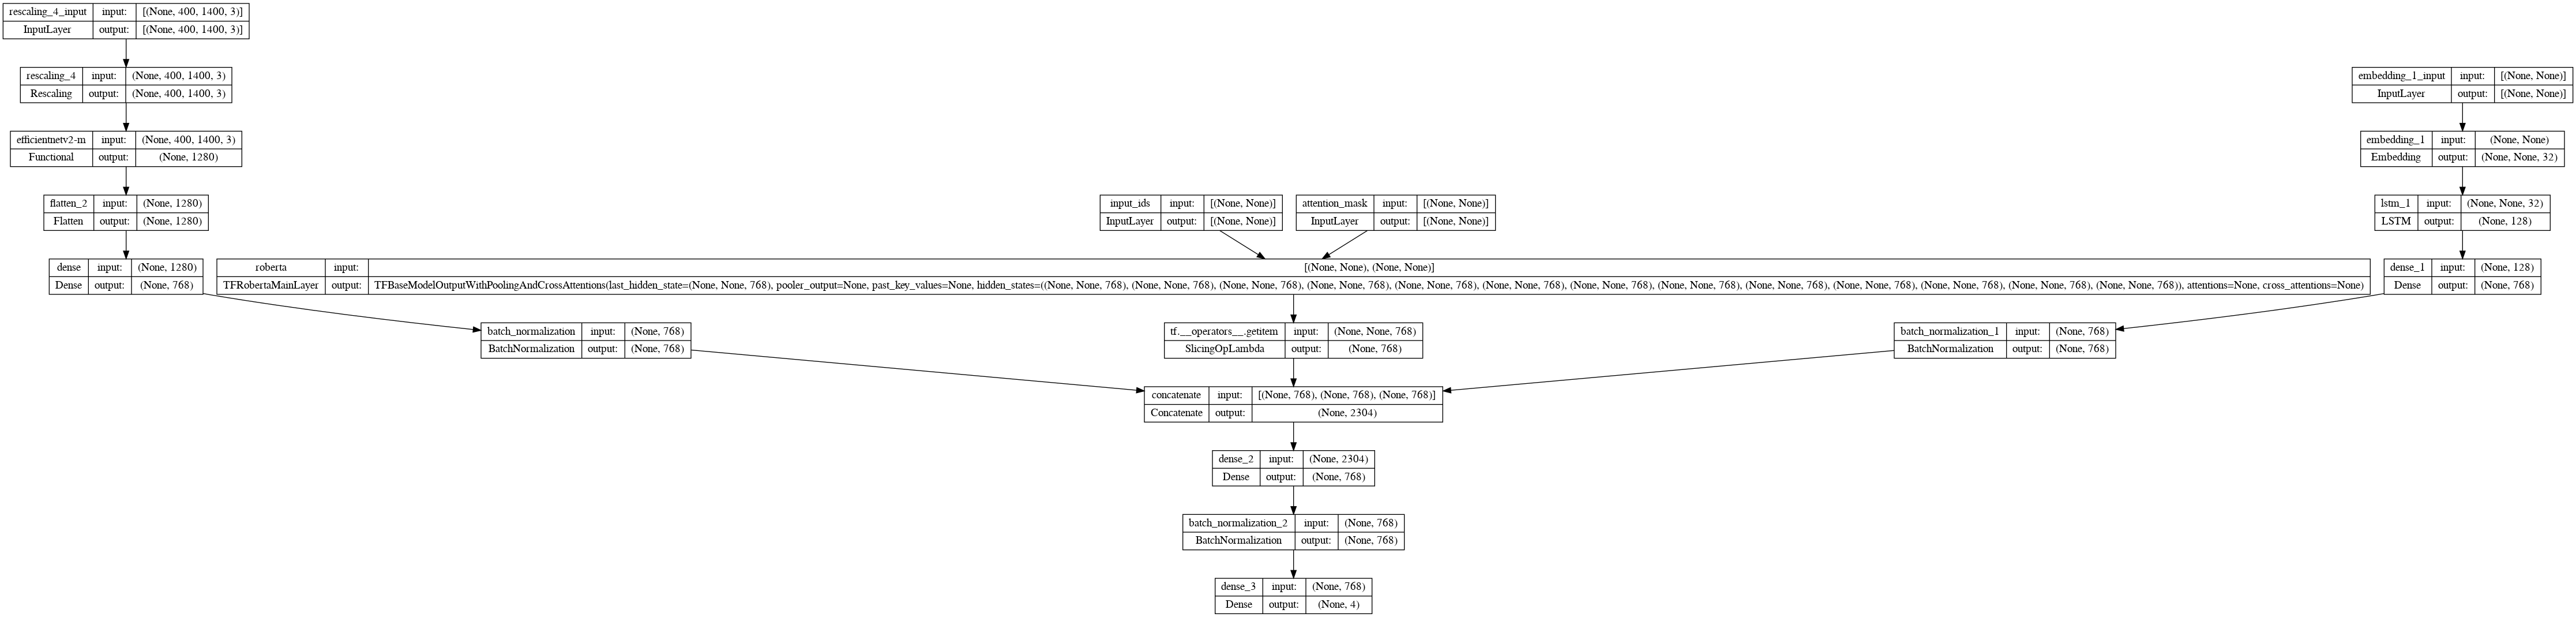

In [ ]:
#multimodal late fusion plain late fusion
#activation- gelu, batch norm , dropouts and 
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW ,LAMB


# dimensions hidden 
hidden_dim=768
multimodal_fusion_neurons_factor=1.0/4
drop_out_prob=.1
num_classes = 4


with strategy.scope():
    
    # Input tensors for 3 different modalities
    modality_1_input = vision_fe.output #seq
    modality_2_input = nlp_fe.output #text
    modality_3_input = seq_fe.output #vision

    modality_1_features = Dense(hidden_dim, activation='gelu')(modality_1_input)
    modality_1_features = BatchNormalization()(modality_1_features)

    # Feature extraction backbones for each modality
    modality_2_features = modality_2_input

    modality_3_features = Dense(hidden_dim, activation='gelu')(modality_3_input)
    modality_3_features = BatchNormalization()(modality_3_features)
    
    
    # Concatenate the features from each modality
    concatenated_features = Concatenate()([modality_1_features, modality_2_features, modality_3_features])

    # add dense multimodal fusion layer on top the concatted features
    multimodal_fusion_neurons_1=768  #int(concatenated_features.shape[1]*multimodal_fusion_neurons_factor)
    late_fusion_1 = Dense(multimodal_fusion_neurons_1, activation='gelu')(concatenated_features)
    batch_normed_1 = BatchNormalization()(late_fusion_1)
    
    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(batch_normed_1)
    model_1 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_1.summary()
    
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

# with strategy.scope():
#      model_1.fit(concatenated_ds)


# model 2 - simple Multiplicative fusion

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 efficientnetv2-m (Functional)  (None, 1280)         53150388    ['rescaling_4[1][0]']            
                                                                                            

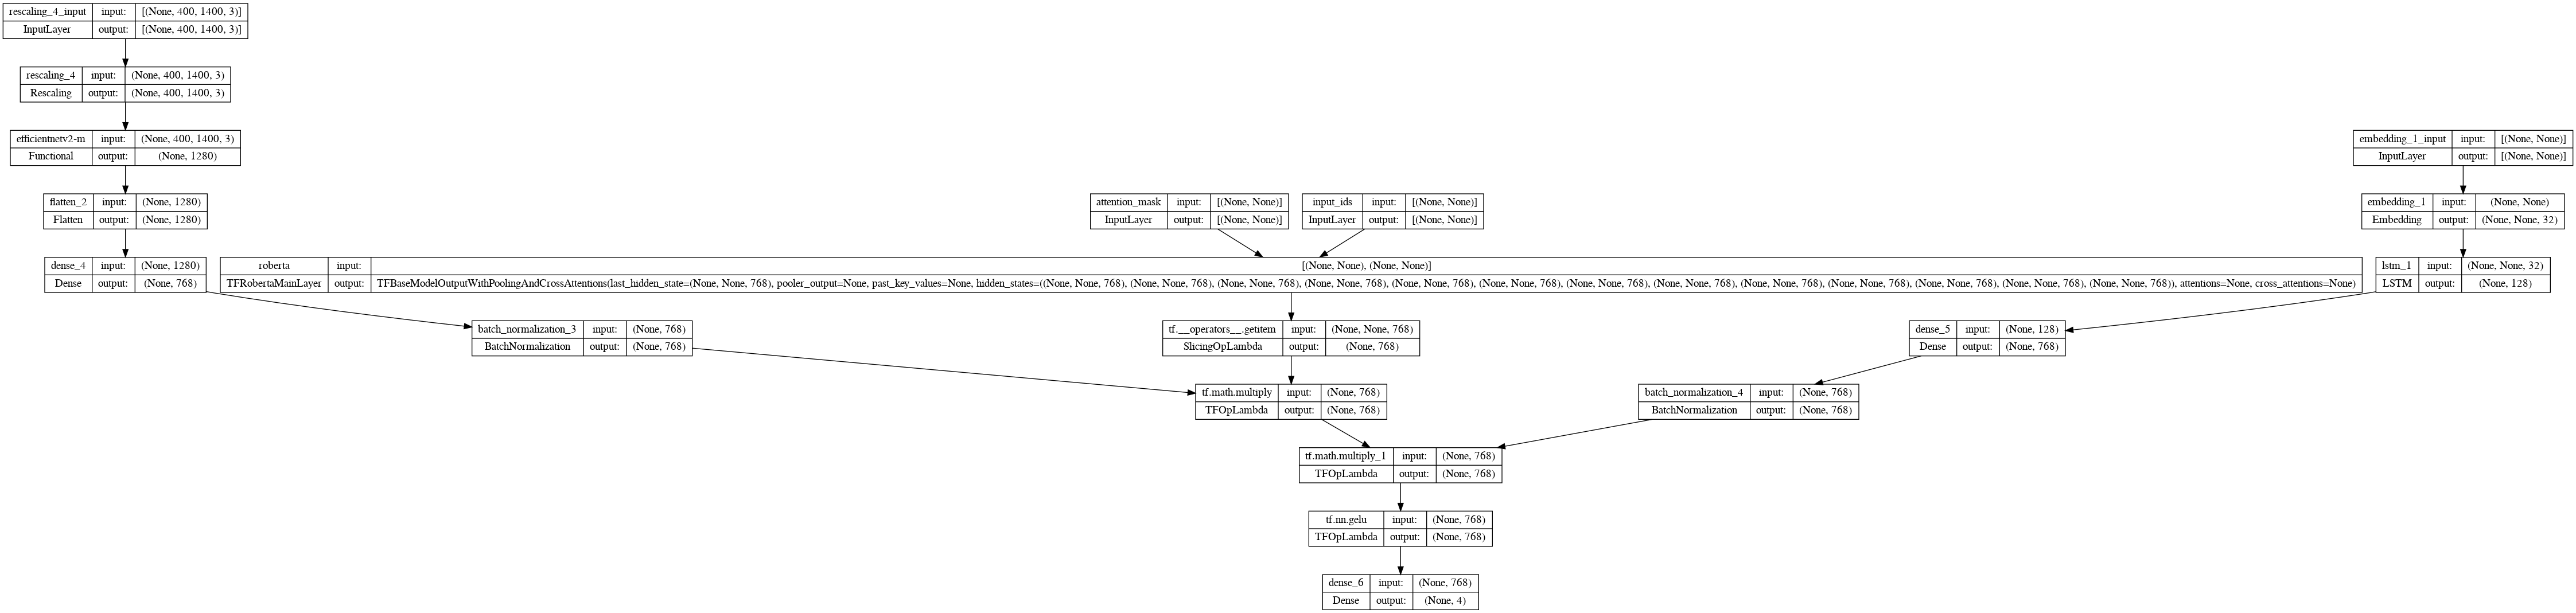

In [22]:
#multimodal late fusion plain late fusion
#activation- gelu, batch norm , dropouts and 
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf 

# dimensions hidden 
hidden_dim=768
drop_out_prob=.1
num_classes = 4
with strategy.scope():
    
    # Input tensors for 3 different modalities
    modality_1_input = vision_fe.output #seq
    modality_2_input = nlp_fe.output #text
    modality_3_input = seq_fe.output #vision

    modality_1_features = Dense(hidden_dim, activation='gelu')(modality_1_input)
    modality_1_features = BatchNormalization()(modality_1_features)

    # Feature extraction backbones for each modality
    modality_2_features = modality_2_input

    modality_3_features = Dense(hidden_dim, activation='gelu')(modality_3_input)
    modality_3_features = BatchNormalization()(modality_3_features)

    combined_modality=tf.nn.gelu(modality_1_features*modality_2_features*modality_3_features)

    # add dense multimodal fusion layer on top the concatted features
    late_fusion = combined_modality
    batch_normed = BatchNormalization()(late_fusion)

    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(late_fusion)

    model_2 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_2.summary()
    
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes=True)

# with strategy.scope():
#     model_2.fit(concatenated_ds,epochs=1)

# model 3- Bilinear gated

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 embedding_1_input (InputLayer)  [(None, None)]      0           []                               
                                                                                            

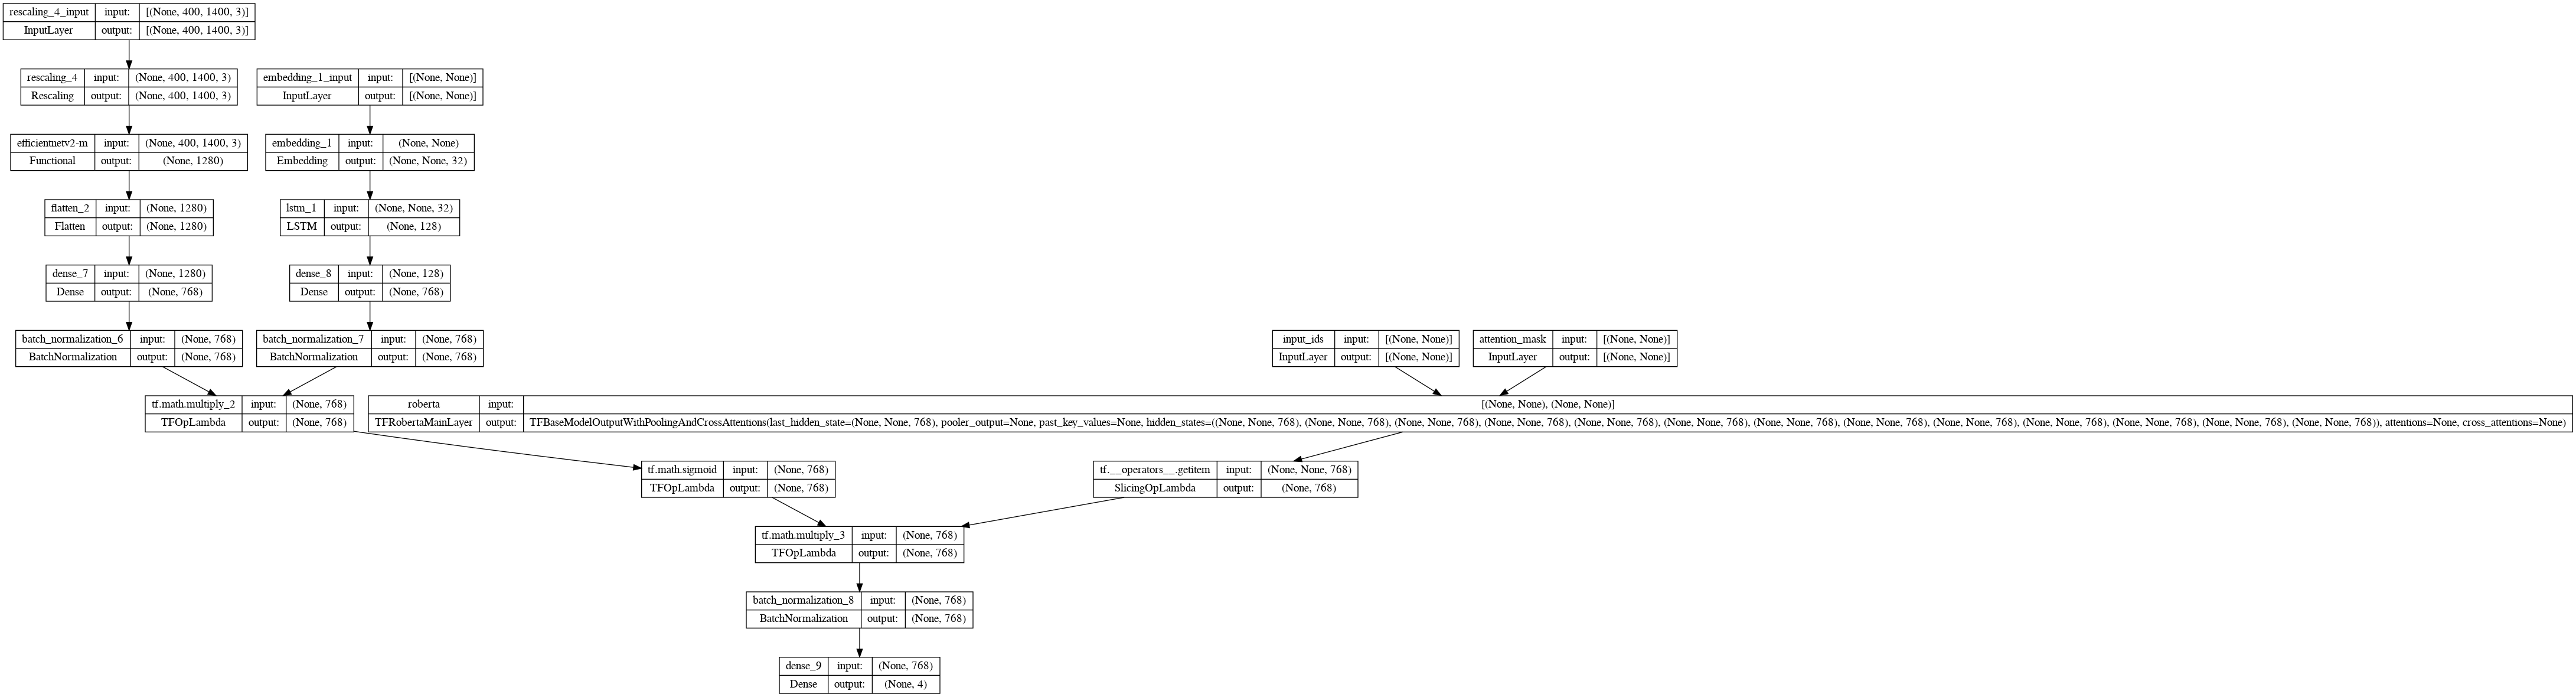

In [23]:
#multimodal late fusion plain late fusion
#activation- gelu, batch norm , dropouts and 
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model

# dimensions hidden 
hidden_dim=768
drop_out_prob=.1
num_classes = 4

with strategy.scope():
    # Input tensors for 3 different modalities
    modality_1_input = vision_fe.output #seq
    modality_2_input = nlp_fe.output #text
    modality_3_input = seq_fe.output #vision

    modality_1_features = Dense(hidden_dim, activation='linear')(modality_1_input)
    modality_1_features= BatchNormalization()(modality_1_features)

    # Feature extraction backbones for each modality
    modality_2_features = modality_2_input

    modality_3_features = Dense(hidden_dim, activation='sigmoid')(modality_3_input)
    modality_3_features= BatchNormalization()(modality_3_features)

    #gated fusion mechanism 
    combined_modality=tf.multiply(modality_2_features,tf.nn.sigmoid(tf.multiply(modality_1_features,modality_3_features)))
    batch_normed = BatchNormalization()(combined_modality)

    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(batch_normed)

    model_3 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_3.summary()
    
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True)


# with strategy.scope():
#     model_3.fit(concatenated_ds)

# model 4- GMU inspired network

In [18]:
#multimodal late fusion plain late fusion
#activation- gelu, batch norm , dropouts and 
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW ,LAMB


# dimensions hidden 
hidden_dim=768
multimodal_fusion_neurons_factor=1.0/4
drop_out_prob=.1
num_classes = 4


with strategy.scope():
    
    # Input tensors for 3 different modalities
    x1 = vision_fe.output #seq
    x2 = nlp_fe.output #text
    x3= seq_fe.output #vision
    
    h1 = Dense(hidden_dim, activation='tanh')(x1)
    h1 = BatchNormalization()(h1)
    
    h2 = Dense(hidden_dim, activation='tanh')(x2)
    h2 = BatchNormalization()(h2)
    
    h3 = Dense(hidden_dim, activation='tanh')(x3)
    h3 = BatchNormalization()(h3)
    
    # Concatenate the features from each modality
    concatenated_features = Concatenate()([x1, x2, x3])
    
    Z = Dense(hidden_dim, activation='sigmoid')(concatenated_features)
    Z = BatchNormalization()(Z)
    
    op_1=tf.multiply(h1,Z)
    op_2=tf.multiply(h2,Z)
    op_3=tf.multiply(h3,Z)
    
    result = tf.add_n([op_1, op_2, op_3])
    
    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(result)


    model_4 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_4.summary()
    
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

# with strategy.scope():
#     model_4.fit(concatenated_ds)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                            

# model 5- cross modal attention

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_input (InputLayer)   [(None, 400, 1400,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling (Rescaling)          (None, 400, 1400, 3  0           ['rescaling_input[0][0]']        
                                )                                                                 
                                                                                                  
 embedding_2_input (InputLayer)  [(None, None)]      0           []                               
                                                                                            

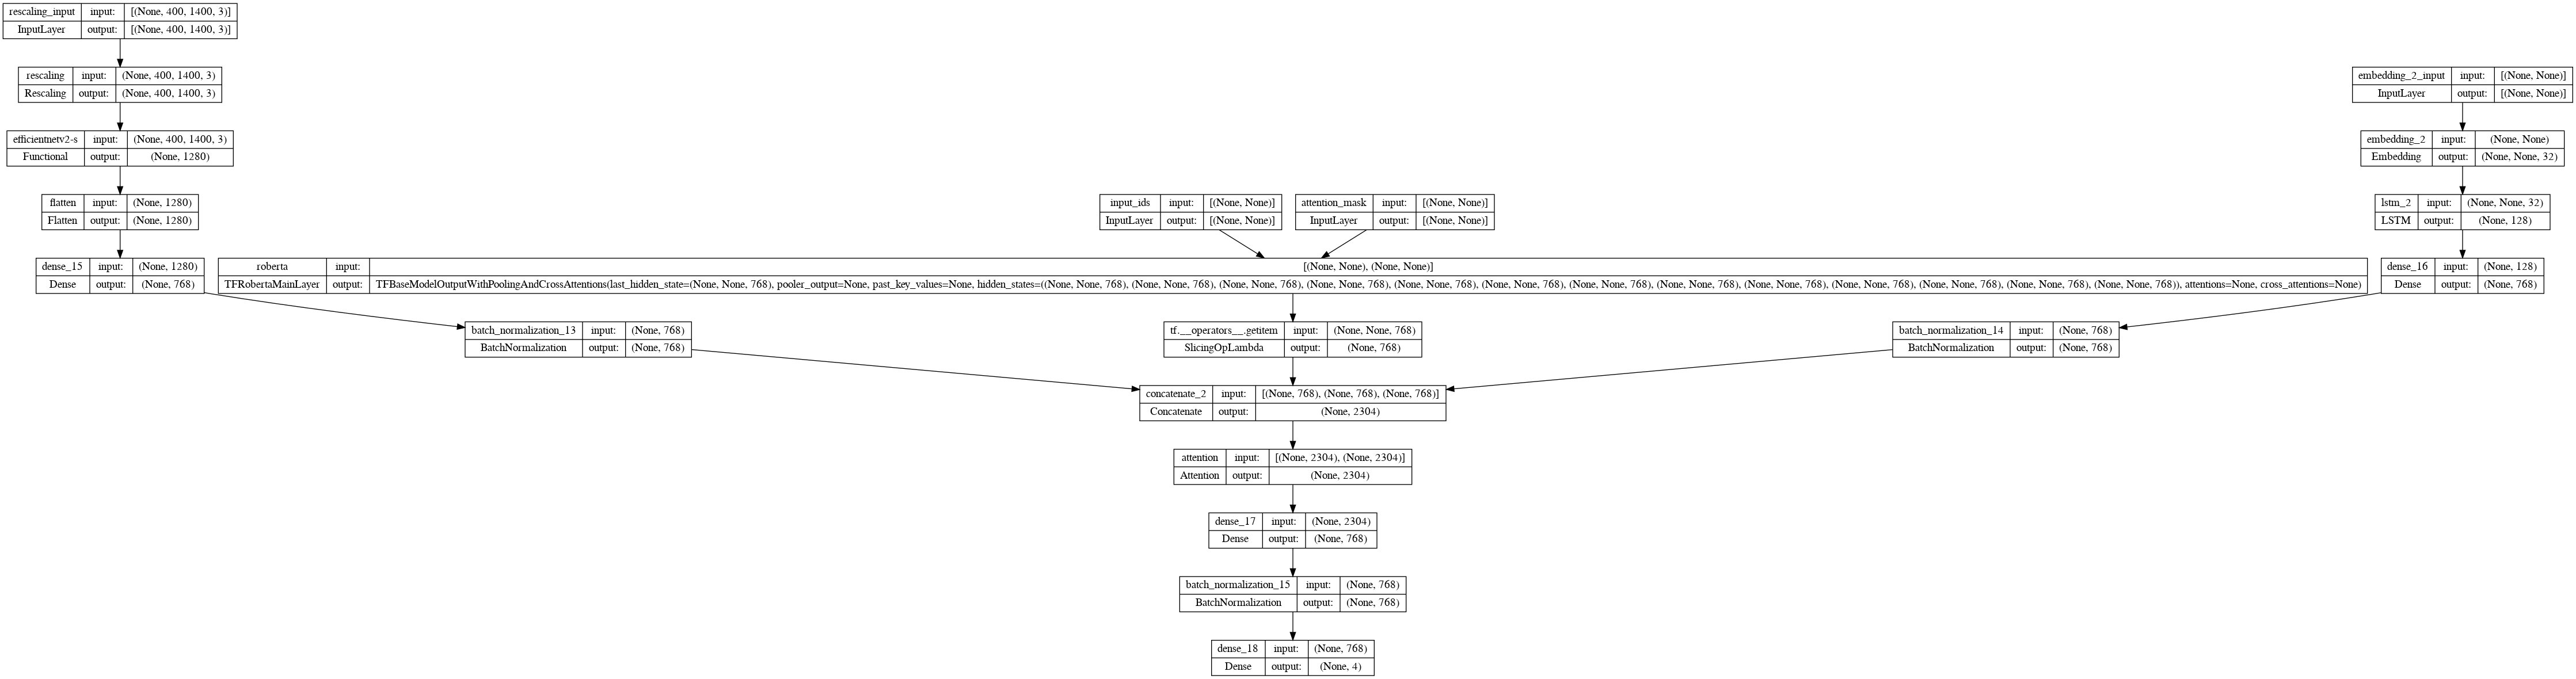

In [25]:
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model


with strategy.scope():
    # Input tensors for 3 different modalities
    modality_1_input = vision_fe.output #seq
    modality_2_input = nlp_fe.output #text
    modality_3_input = seq_fe.output #vision

    modality_1_features = Dense(hidden_dim, activation='linear')(modality_1_input)
    modality_1_features= BatchNormalization()(modality_1_features)

    # Feature extraction backbones for each modality
    modality_2_features = modality_2_input

    modality_3_features = Dense(hidden_dim, activation='sigmoid')(modality_3_input)
    modality_3_features= BatchNormalization()(modality_3_features)


    # Concatenate the features from each modality
    concatenated_features = Concatenate()([modality_1_features, modality_2_features, modality_3_features])

    #add self attention mechanism
    attention_layer_concat_features = Attention()([concatenated_features, concatenated_features])

    # add dense multimodal fusion layer on top the concatted features
    multimodal_fusion_neurons=768
    late_fusion = Dense(multimodal_fusion_neurons, activation='gelu')(attention_layer_concat_features)
    batch_normed = BatchNormalization()(late_fusion)

    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(batch_normed)

    model_5 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_5.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_5.summary()
    
    
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

# with strategy.scope():
#     model_5.fit(concatenated_ds)
    

# model 6- Multihead attention

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_input (InputLayer)   [(None, 400, 1400,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling (Rescaling)          (None, 400, 1400, 3  0           ['rescaling_input[0][0]']        
                                )                                                                 
                                                                                                  
 embedding_2_input (InputLayer)  [(None, None)]      0           []                               
                                                                                            

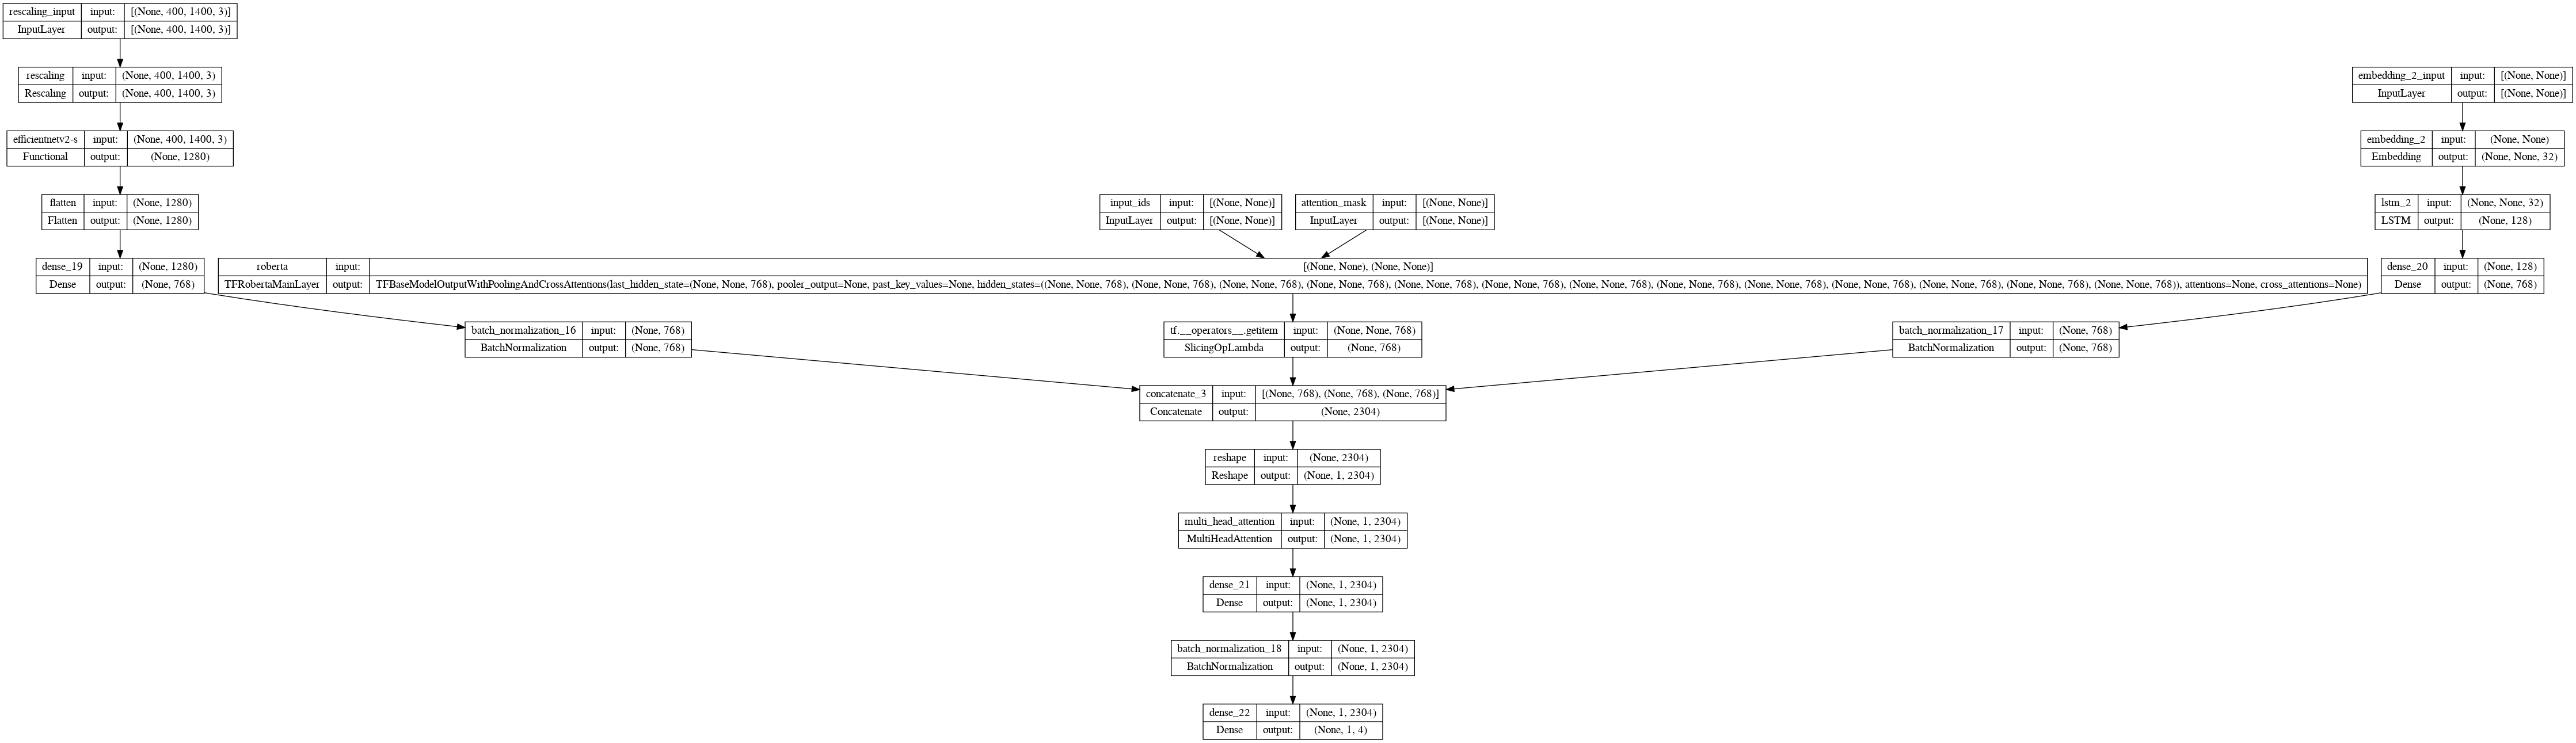

In [26]:
## multihead attention
from tensorflow.keras.layers import Input, Concatenate, Dense, MultiHeadAttention, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model


with strategy.scope():

    # Input tensors for 3 different modalities
    modality_1_input = vision_fe.output #seq
    modality_2_input = nlp_fe.output #text
    modality_3_input = seq_fe.output #vision

    # Feature extraction backbones for each modality
    modality_2_features = modality_2_input

    modality_1_features = Dense(hidden_dim, activation='gelu')(modality_1_input)
    modality_1_features = BatchNormalization()(modality_1_features)

    modality_3_features = Dense(hidden_dim, activation='gelu')(modality_3_input)
    modality_3_features = BatchNormalization()(modality_3_features)

    # Concatenate the features from each modality
    concatenated_features = Concatenate()([modality_1_features, modality_2_features, modality_3_features])
    reshaped_features=tf.keras.layers.Reshape((-1,concatenated_features.shape[1]))(concatenated_features)


    # Add multi-head attention layer
    multi_head_attention = MultiHeadAttention(num_heads=8, key_dim=concatenated_features.shape[1] // 8)

    attention_layer_concat_features = multi_head_attention(reshaped_features, reshaped_features)
    #attention_layer_concat_features = Flatten()(attention_layer_concat_features)


    # add dense multimodal fusion layer on top the concatted features
    multimodal_fusion_neurons=2304
    late_fusion = Dense(multimodal_fusion_neurons, activation='gelu')(attention_layer_concat_features)
    batch_normed = BatchNormalization()(late_fusion)

    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(batch_normed)

    model_6 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_6.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_6.summary()
    

from tensorflow.keras.utils import plot_model
plot_model(model_6, show_shapes=True)

# with strategy.scope():
#     model_6.fit(concatenated_ds)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_input (InputLayer)   [(None, 400, 1400,   0           []                               
                                3)]                                                               
                                                                                                  
 rescaling (Rescaling)          (None, 400, 1400, 3  0           ['rescaling_input[0][0]']        
                                )                                                                 
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                            

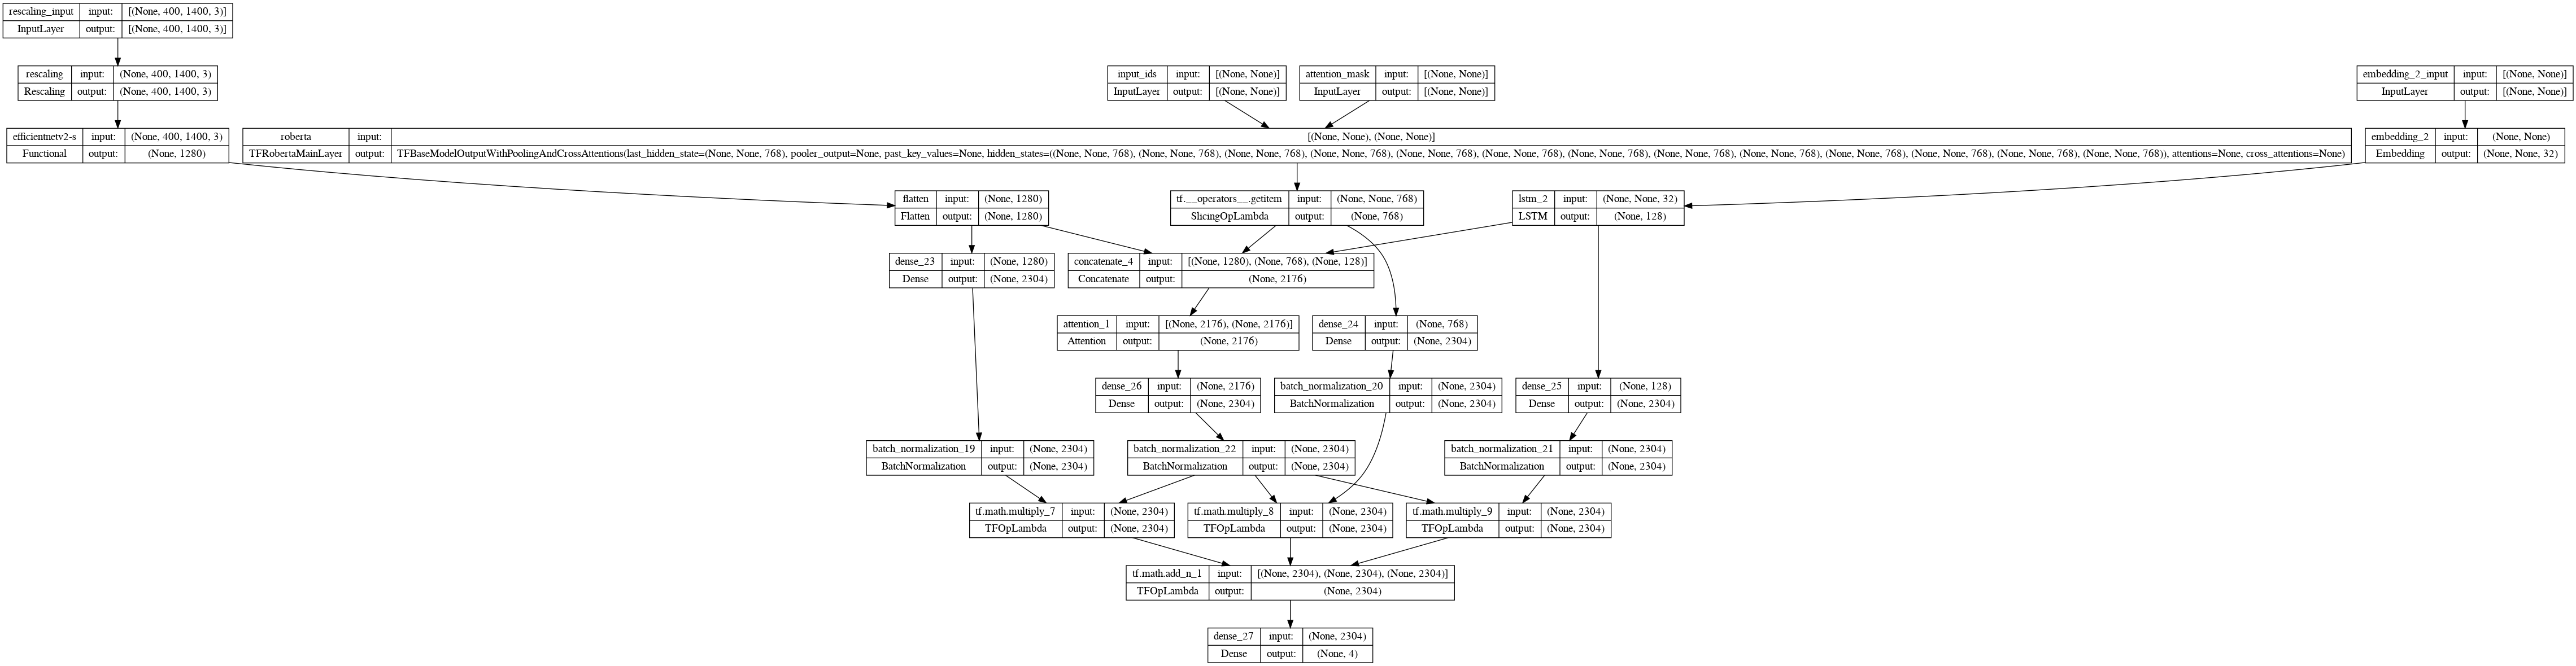

In [27]:
#ultimate model
from tensorflow.keras.layers import Input, Concatenate, Dense, Attention, BatchNormalization ,Dropout
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW ,LAMB
from tensorflow.keras.layers import Input, Concatenate, Dense, MultiHeadAttention, BatchNormalization, Dropout, Flatten
from tensorflow.keras.models import Model


# dimensions hidden 
hidden_dim=2304
multimodal_fusion_neurons_factor=1.0/4
drop_out_prob=.1
num_classes = 4


with strategy.scope():
    
    # Input tensors for 3 different modalities
    x1 = vision_fe.output #seq
    x2 = nlp_fe.output #text
    x3= seq_fe.output #vision
    
    h1 = Dense(hidden_dim, activation='tanh')(x1)
    h1 = BatchNormalization()(h1)
    
    h2 = Dense(hidden_dim, activation='tanh')(x2)
    h2 = BatchNormalization()(h2)
    
    h3 = Dense(hidden_dim, activation='tanh')(x3)
    h3 = BatchNormalization()(h3)
    
    # Concatenate the features from each modality
    concatenated_features = Concatenate()([x1, x2, x3])
    #add self attention mechanism
    attention_layer_concat_features = Attention()([concatenated_features, concatenated_features])
    
    
    Z = Dense(hidden_dim, activation='sigmoid')(attention_layer_concat_features)
    Z = BatchNormalization()(Z)
    
    op_1=tf.multiply(h1,Z)
    op_2=tf.multiply(h2,Z)
    op_3=tf.multiply(h3,Z)
    
    result = tf.add_n([op_1, op_2, op_3])
    
    # Add a dense layer with softmax activation function on top of the attended output
    outputs = Dense(num_classes, activation='softmax')(result)

    model_4 = Model(inputs=[vision_fe.input,nlp_fe.input[0],nlp_fe.input[1],seq_fe.input], outputs=outputs)

    learning_rate=2e-5
    optimizer_2=LAMB(learning_rate)
    model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model_4.summary()
    
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

# with strategy.scope():
#     model_4.fit(concatenated_ds)


# building the training loop

In [19]:
import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=8
batch_size=batch_per_gpu*devices


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
no of devices: 4


In [20]:
from datasets import Dataset
import ast
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from PIL import Image
from transformers import DataCollatorWithPadding
from datasets import concatenate_datasets

class Multimodal_val_dataframe_to_dataset:
    def __init__(self,column_list,nlp_tokenizer,seq_tokenizer,seq_max_length=1000
                 ,max_length=512,num_proc=7):
        
        self.column_list=column_list
        self.tokenizer=nlp_tokenizer
        self.max_length=max_length
        self.num_proc=num_proc
        self.seq_tokenizer=seq_tokenizer
        self.seq_max_length=seq_max_length

    def make_sentence(self,sent):
        new=sent.split("[~end_of_font~]")
        new="".join(new)
        new=" ".join(eval(new))

        return new

    def setting_up_labels(self,label):
        label=label.lower()
        if("basic" in label):
            return "basic"
        if("overlap" in label):
            return "overlap"
        if("proof" in label):
            return "proof"
        if("theorem" in label):
            return  "theorem"
        else:
            return "theorem"
        
        
    def setting_up_labels_1(self,label):
        label=label.lower()
        if("basic" in label):
            return 0
        if("overlap" in label):
            return 3
        if("proof" in label):
            return 1
        if("theorem" in label):
            return  2
        

    def tokenize_function(self,examples):
        return self.tokenizer(examples["text"],truncation=True,max_length=256)
    
    def tokenize_function_seq(self,examples):
        val_tokenized_train = self.seq_tokenizer.texts_to_sequences(examples["global_fonts"])
        padded= pad_sequences(val_tokenized_train, maxlen=self.seq_max_length)
        return {"embedding_2_input": padded}

    
    def fit(self,df,batch_no):
        # try:
            df=df[self.column_list]

            #drop nan
            df=df.dropna() #not drp

            #filter no char text
            df["text"]=df["text"].replace("",None) #remove
            df=df.dropna()#None
            
            #assign labels
            df['label']=df["label"].apply(self.setting_up_labels)

            #filter no char text
            df["text"]=df["text"].replace("",None)
            final_df=df.dropna()
            
            final_df["label"]=final_df["label"].apply(self.setting_up_labels_1)
            final_df=final_df.dropna()
            
            #preprocessing for font
            
            def fonts_in_single_para(val):
                literal=ast.literal_eval(val)
                combined_fonts=[font_line.strip() for font_line in literal]
                combined_para_fonts=" ".join(combined_fonts)
                combined_para_fonts=combined_para_fonts.split()
                return combined_para_fonts

            def continuous_fonts_clubbed(val):
                """clubs fonts that are together in a group sequence"""
                fonts_unique_order=[]
                for font in val:
                    try:
                        last_font=fonts_unique_order[-1]
                    except:
                        fonts_unique_order.append(font)
                        continue
                    if(font!=last_font):
                        fonts_unique_order.append(font)

                return fonts_unique_order
            
            
            final_df["global_fonts"]=final_df["global_fonts"].apply(fonts_in_single_para)
            final_df["global_fonts"]=final_df["global_fonts"].apply(continuous_fonts_clubbed)
            
            final_df=final_df.dropna()
            
            #building the dataset
            dataset = Dataset.from_pandas(final_df)
            
            print("-----preprocessing NLP")
            preprocessed = dataset.map(self.tokenize_function, batched=True,num_proc=self.num_proc)
            
            print("-----preprocessing Seq")
            combined= preprocessed.map(self.tokenize_function_seq, batched=True,num_proc=self.num_proc)
            
            print("-----preprocessing vision")
            #build a tf dataset object for images
            
            from datasets import load_dataset, Image

            dataset = Dataset.from_dict({"rescaling_input": combined["file_names"]}).cast_column("rescaling_input", Image())
            concatenated_dataset = concatenate_datasets([dataset, combined], axis=1)

            return concatenated_dataset
            
            
        # except:
        #     return -1


In [21]:
#reordering file name accroding to some predefined run (which is here nlp)

train_path="/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/**.csv"
import glob
files=glob.glob(train_path)
files

file_path="/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/start_mlm_forft_res.txt"
import os
base="/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/"
with open(file_path,"r") as f:
    lines=f.readlines()
    
start=[]
for line in lines:
    val=line.split(",")[0][2:]
    start.append(os.path.join(base,val))

for file in files:
    if(file in start):
        continue
    else:
        start.append(file)
        
files=start
files=files[:15]

In [6]:
#generate validation dataset
import pandas as pd
import glob
from tqdm import tqdm
import pandas as pd
import pickle
import numpy as np
import cv2

clean_csv_paths="/gpfswork/rech/zpf/uyf36me/finetuning_multimodal/multimodal_val.csv" ####validation path

df=pd.read_csv(clean_csv_paths)


from transformers import RobertaTokenizerFast
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/roberta_from_scratch_ft"
tokenizer=RobertaTokenizerFast.from_pretrained(path_pretrained)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

filepath = "/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/tokenizer_52000_v1.pkl"

with open(filepath, 'rb') as f:
    seq_tokenizer = pickle.load(f)
    print(len(seq_tokenizer.word_counts))
    
    
column_list=["text","label","pdf_path","page_no","top_left","bot_right","global_fonts","file_names"]
temp=Multimodal_val_dataframe_to_dataset(column_list=column_list,nlp_tokenizer=tokenizer,
                                     seq_tokenizer=seq_tokenizer,num_proc=10)

batch_no="val_data"
val_dataset=temp.fit(df=df,batch_no=batch_no)


tf_ds_seq = val_dataset.to_tf_dataset(
            columns=["embedding_2_input"],
            batch_size=batch_size,
            shuffle=False
            )

tf_ds_nlp = val_dataset.to_tf_dataset(
                    columns=['input_ids', 'attention_mask'],
                    shuffle=False,
                    batch_size=batch_size,
                    collate_fn=data_collator)

tf_ds_vis = val_dataset.to_tf_dataset(
                    columns=['rescaling_input'],
                    shuffle=False,
                    batch_size=batch_size)

labels= val_dataset.to_tf_dataset(
                        columns=['label'],
                        shuffle=False,
                        batch_size=batch_size)

inputs=tf_ds_seq,tf_ds_nlp,tf_ds_vis


input_ids=tf_ds_nlp.map(lambda x:x['input_ids'])
attention_mask=tf_ds_nlp.map(lambda x:x['attention_mask'])


input_ids=input_ids.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])
attention_mask=attention_mask.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])

val_dataset_ds = tf.data.Dataset.zip(((
   tf_ds_vis,
   input_ids,
   attention_mask,
    tf_ds_seq
), labels))

val_dataset_final=val_dataset_ds.prefetch(tf.data.AUTOTUNE) ###<<< remove the last part if you dont want shuffle

4031
-----preprocessing NLP


-----preprocessing Seq


-----preprocessing vision


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


epoch_loss = 0.0
epoch_accuracy = 0.0
num_batches = 0

        
for batch in tqdm(train_dataset_final):
    # Train on batch
    try:
        loss, accuracy = model.train_on_batch(batch[0], batch[1])

        # Print batch loss and accuracy
        # print("Batch Loss: {:.4f}".format(loss))
        # print("Batch Accuracy: {:.4f}".format(accuracy))

        # Update epoch loss and accuracy
        epoch_loss += loss
        epoch_accuracy += accuracy
        num_batches += 1
    except:
        continue

# Calculate average loss and accuracy for the epoch so far
avg_loss = epoch_loss / num_batches
avg_accuracy = epoch_accuracy / num_batches

# Print average loss and accuracy so far
print("Avg Loss: {:.4f}".format(avg_loss))
print("Avg Accuracy: {:.4f}".format(avg_accuracy))

In [22]:
import warnings
warnings.filterwarnings('ignore')


log_file="/linkhome/rech/gennsp01/uyf36me/work/finetuning_multimodal/model_1.txt" ###change this
model_path="/gpfswork/rech/zpf/ubq16fv/model_4_7" ###change this model_4_0_1

if(os.path.exists(model_path)):
    with strategy.scope():
        model = tf.keras.models.load_model(model_path)
        print("model loaded: ", model_path)
        
        learning_rate=2e-5
        optimizer_2=LAMB(learning_rate)
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #model.summary()
        
def get_last_run(log_file):
    with open(log_file,"r") as f:
        lines=f.readlines()
    f.close()
    
    files=[]
    for line in lines:
        files.append(line.split(",")[0])
        
    return files

def append_last_run(val,log_file):
    with open(log_file,"a") as f:
        f.write(val)

# skips=["batch_28.csv","batch_18.csv","batch_7.csv","batch_2.csv","batch_0.csv",
#       "batch_108.csv","batch_106.csv","batch_85.csv","batch_123.csv"]

skips=["batch_7.csv", "batch_2.csv", "batch_0.csv", "batch_108.csv", "batch_106.csv", "batch_85.csv", "batch_123.csv", "batch_48.csv"]
nb_t = 8

for i,file in tqdm(enumerate(files)):
    
    #get readings from past run
    try:
        run_so_far=get_last_run(log_file) #if already ran some batches then skip this one
        if(file in run_so_far): #or file in skips
            continue
        else:
            print(file)
            print("not in previous runs, hence running on this batch")
    except FileNotFoundError:
        pass
    if(file.split("/")[-1] in skips):
        continue
    print("doing--", file)
    
    df=pd.read_csv(file)
    column_list=["pdf_alto_text","label","pdf_path","page_no","top_left","bot_right","global_fonts"]
    temp=Multimodal_dataframe_to_dataset(column_list=column_list,nlp_tokenizer=tokenizer,
                                     seq_tokenizer=seq_tokenizer,num_proc=10)

    
    batch_no=file.rsplit("/")[-1].split(".")[0]
    train_dataset=temp.fit(df=df,batch_no=batch_no)
    
    try:
        tf_ds_seq = train_dataset.to_tf_dataset(
                columns=["embedding_2_input"],
                batch_size=batch_size,
                shuffle=False
                )

        tf_ds_nlp = train_dataset.to_tf_dataset(
                        columns=['input_ids', 'attention_mask'],
                        shuffle=False,
                        batch_size=batch_size,
                        collate_fn=data_collator)

        tf_ds_vis = train_dataset.to_tf_dataset(
                        columns=['rescaling_input'],
                        shuffle=False,
                        batch_size=batch_size)

        labels=train_dataset.to_tf_dataset(
                            columns=['label'],
                            shuffle=False,
                            batch_size=batch_size)
        
    except:
        continue

    inputs=tf_ds_seq,tf_ds_nlp,tf_ds_vis
    
    
    input_ids=tf_ds_nlp.map(lambda x:x['input_ids'])
    attention_mask=tf_ds_nlp.map(lambda x:x['attention_mask'])

    input_ids=input_ids.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])
    attention_mask=attention_mask.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])

    train_dataset_ds = tf.data.Dataset.zip(((
                       tf_ds_vis,
                       input_ids,
                       attention_mask,
                        tf_ds_seq
                        ), labels))
    
    print(batch_size)
    train_dataset_final=train_dataset_ds.shuffle(buffer_size=batch_size).prefetch(tf.data.AUTOTUNE) ###<<< remove the last part
    
    print(model.summary())
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
    
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = 0

    '''
    for batch in tqdm(train_dataset_final):
         # Train on batch
        try:
            with strategy.scope():
                loss, accuracy = model.train_on_batch(batch[0], batch[1]);

             # Print batch loss and accuracy
             # print("Batch Loss: {:.4f}".format(loss))
             # print("Batch Accuracy: {:.4f}".format(accuracy))

             # Update epoch loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy
            num_batches += 1
        except:
            continue

     # Calculate average loss and accuracy for the epoch so far
    train_loss = epoch_loss / num_batches
    train_acc = epoch_accuracy / num_batches

     # Print average loss and accuracy so far
    print("Avg Loss: {:.4f}".format(train_loss))
    print("Avg Accuracy: {:.4f}".format(train_acc))
    '''
    '''
    sample1 = train_dataset_final.take(1974)

    history1 = model.fit(sample1)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_1")
    
    train_dataset_final = train_dataset_final.skip(1974)
    
    sample2 = train_dataset_final.take(1974)

    history2 = model.fit(sample2)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_2")
    
    train_dataset_final = train_dataset_final.skip(1974)
    
    sample3 = train_dataset_final.take(1974)

    history3 = model.fit(sample3)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_3")
    
    train_dataset_final = train_dataset_final.skip(1974)
    '''
    
    history = model.fit(train_dataset_final)
    
    train_loss=history.history['loss'] #(history1.history['loss']+history2.history['loss']+history3.history['loss'])/3
    #val_loss=history.history['val_loss']
    train_acc=history.history['sparse_categorical_accuracy'] #(history1.history['sparse_categorical_accuracy']+history2.history['sparse_categorical_accuracy']+history3.history['sparse_categorical_accuracy'])/3
    #val_acc=history.history['val_sparse_categorical_accuracy']

    line_to_write=f'{file},{train_loss},{train_acc}\n'
    print(line_to_write)
    #append_last_run(line_to_write,log_file)
    #model_path+=str(i)

    #saving the model
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_" + str(nb_t))
    nb_t += 1
    break
    
    

model loaded:  /gpfswork/rech/zpf/ubq16fv/model_4_7


0it [00:00, ?it/s]

/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_7.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_2.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_0.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_108.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_106.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_85.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_123.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_


0it [00:00, ?it/s]
1756it [00:00, 17556.25it/s]
4293it [00:00, 22150.01it/s]
6865it [00:00, 23775.90it/s]
9445it [00:00, 24572.67it/s]
12040it [00:00, 25068.02it/s]
14641it [00:00, 25386.74it/s]
17232it [00:00, 25557.05it/s]
19813it [00:00, 25635.77it/s]
22412it [00:00, 25745.66it/s]
24987it [00:01, 25739.48it/s]
27576it [00:01, 25784.45it/s]
30155it [00:01, 25748.34it/s]
32732it [00:01, 25753.53it/s]
35309it [00:01, 25755.89it/s]
37885it [00:01, 25702.68it/s]
40473it [00:01, 25753.50it/s]
43080it [00:01, 25847.95it/s]
45665it [00:01, 25811.63it/s]
48248it [00:01, 25815.82it/s]
50830it [00:02, 25778.67it/s]
53408it [00:02, 25718.82it/s]
55981it [00:02, 25720.96it/s]
58554it [00:02, 25626.07it/s]
61124it [00:02, 25647.67it/s]
63689it [00:02, 25576.72it/s]
66247it [00:02, 25499.31it/s]
68802it [00:02, 25514.13it/s]
71373it [00:02, 25570.74it/s]
73935it [00:02, 25583.34it/s]
76494it [00:03, 25477.24it/s]
79042it [00:03, 25413.02it/s]
81599it [00:03, 25457.90it/s]
84145it [00:03, 25421.12

---checking for valid file paths



100%|██████████| 182769/182769 [01:13<00:00, 2499.83it/s]


-----before reading images (182769, 8)
-----after reading images (182769, 8)
-----preprocessing NLP



Map (num_proc=10): 100%|█████████▉| 182493/182769 [00:06<00:00, 18611.25 examples/s]
                                                                                    

-----preprocessing Seq



Map (num_proc=10):  93%|█████████▎| 170216/182769 [00:02<00:00, 114134.81 examples/s]
                                                                                     

-----preprocessing vision
32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                               

2023-05-04 13:43:14.197112: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 182769
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:175"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1


2023-05-04 13:44:41.183154: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5712/5712 [==============================] - 2571s 430ms/step - loss: 0.5719 - sparse_categorical_accuracy: 0.7843
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_114.csv,[0.5718927383422852],[0.784345269203186]



INFO:tensorflow:Assets written to: /gpfswork/rech/zpf/ubq16fv/model_4_8/assets


INFO:tensorflow:Assets written to: /gpfswork/rech/zpf/ubq16fv/model_4_8/assets
10it [46:57, 281.78s/it]


In [23]:
import warnings
warnings.filterwarnings('ignore')


log_file="/linkhome/rech/gennsp01/uyf36me/work/finetuning_multimodal/model_1.txt" ###change this
model_path="/gpfswork/rech/zpf/ubq16fv/model_4_8" ###change this model_4_0_1

if(os.path.exists(model_path)):
    with strategy.scope():
        model = tf.keras.models.load_model(model_path)
        print("model loaded: ", model_path)
        
        learning_rate=2e-5
        optimizer_2=LAMB(learning_rate)
        model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_2, metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #model.summary()
        
def get_last_run(log_file):
    with open(log_file,"r") as f:
        lines=f.readlines()
    f.close()
    
    files=[]
    for line in lines:
        files.append(line.split(",")[0])
        
    return files

def append_last_run(val,log_file):
    with open(log_file,"a") as f:
        f.write(val)

# skips=["batch_28.csv","batch_18.csv","batch_7.csv","batch_2.csv","batch_0.csv",
#       "batch_108.csv","batch_106.csv","batch_85.csv","batch_123.csv"]

skips=["batch_7.csv", "batch_2.csv", "batch_0.csv", "batch_108.csv", "batch_106.csv", "batch_85.csv", "batch_123.csv", "batch_48.csv", "batch_114.csv"]
nb_t = 9

for i,file in tqdm(enumerate(files)):
    
    #get readings from past run
    try:
        run_so_far=get_last_run(log_file) #if already ran some batches then skip this one
        if(file in run_so_far): #or file in skips
            continue
        else:
            print(file)
            print("not in previous runs, hence running on this batch")
    except FileNotFoundError:
        pass
    if(file.split("/")[-1] in skips):
        continue
    print("doing--", file)
    
    df=pd.read_csv(file)
    column_list=["pdf_alto_text","label","pdf_path","page_no","top_left","bot_right","global_fonts"]
    temp=Multimodal_dataframe_to_dataset(column_list=column_list,nlp_tokenizer=tokenizer,
                                     seq_tokenizer=seq_tokenizer,num_proc=10)

    
    batch_no=file.rsplit("/")[-1].split(".")[0]
    train_dataset=temp.fit(df=df,batch_no=batch_no)
    
    try:
        tf_ds_seq = train_dataset.to_tf_dataset(
                columns=["embedding_2_input"],
                batch_size=batch_size,
                shuffle=False
                )

        tf_ds_nlp = train_dataset.to_tf_dataset(
                        columns=['input_ids', 'attention_mask'],
                        shuffle=False,
                        batch_size=batch_size,
                        collate_fn=data_collator)

        tf_ds_vis = train_dataset.to_tf_dataset(
                        columns=['rescaling_input'],
                        shuffle=False,
                        batch_size=batch_size)

        labels=train_dataset.to_tf_dataset(
                            columns=['label'],
                            shuffle=False,
                            batch_size=batch_size)
        
    except:
        continue

    inputs=tf_ds_seq,tf_ds_nlp,tf_ds_vis
    
    
    input_ids=tf_ds_nlp.map(lambda x:x['input_ids'])
    attention_mask=tf_ds_nlp.map(lambda x:x['attention_mask'])

    input_ids=input_ids.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])
    attention_mask=attention_mask.unbatch().padded_batch(batch_size=batch_size, padded_shapes=[512])

    train_dataset_ds = tf.data.Dataset.zip(((
                       tf_ds_vis,
                       input_ids,
                       attention_mask,
                        tf_ds_seq
                        ), labels))
    
    print(batch_size)
    train_dataset_final=train_dataset_ds.shuffle(buffer_size=batch_size).prefetch(tf.data.AUTOTUNE) ###<<< remove the last part
    
    print(model.summary())
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
    
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    num_batches = 0

    '''
    for batch in tqdm(train_dataset_final):
         # Train on batch
        try:
            with strategy.scope():
                loss, accuracy = model.train_on_batch(batch[0], batch[1]);

             # Print batch loss and accuracy
             # print("Batch Loss: {:.4f}".format(loss))
             # print("Batch Accuracy: {:.4f}".format(accuracy))

             # Update epoch loss and accuracy
            epoch_loss += loss
            epoch_accuracy += accuracy
            num_batches += 1
        except:
            continue

     # Calculate average loss and accuracy for the epoch so far
    train_loss = epoch_loss / num_batches
    train_acc = epoch_accuracy / num_batches

     # Print average loss and accuracy so far
    print("Avg Loss: {:.4f}".format(train_loss))
    print("Avg Accuracy: {:.4f}".format(train_acc))
    '''
    '''
    sample1 = train_dataset_final.take(1974)

    history1 = model.fit(sample1)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_1")
    
    train_dataset_final = train_dataset_final.skip(1974)
    
    sample2 = train_dataset_final.take(1974)

    history2 = model.fit(sample2)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_2")
    
    train_dataset_final = train_dataset_final.skip(1974)
    
    sample3 = train_dataset_final.take(1974)

    history3 = model.fit(sample3)
    
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_2_3")
    
    train_dataset_final = train_dataset_final.skip(1974)
    '''
    
    history = model.fit(train_dataset_final)
    
    train_loss=history.history['loss'] #(history1.history['loss']+history2.history['loss']+history3.history['loss'])/3
    #val_loss=history.history['val_loss']
    train_acc=history.history['sparse_categorical_accuracy'] #(history1.history['sparse_categorical_accuracy']+history2.history['sparse_categorical_accuracy']+history3.history['sparse_categorical_accuracy'])/3
    #val_acc=history.history['val_sparse_categorical_accuracy']

    line_to_write=f'{file},{train_loss},{train_acc}\n'
    print(line_to_write)
    #append_last_run(line_to_write,log_file)
    #model_path+=str(i)

    #saving the model
    model.save("/gpfswork/rech/zpf/ubq16fv/model_4_" + str(nb_t))
    nb_t += 1
    break
    
    

model loaded:  /gpfswork/rech/zpf/ubq16fv/model_4_8


0it [00:00, ?it/s]

/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_7.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_2.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_0.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_108.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_106.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_85.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_123.csv
not in previous runs, hence running on this batch
/linkhome/rech/gennsp01/uyf36me/work/finetuning_


0it [00:00, ?it/s]
1725it [00:00, 17245.49it/s]
4305it [00:00, 22274.06it/s]
6906it [00:00, 23979.34it/s]
9554it [00:00, 24965.93it/s]
12151it [00:00, 25324.92it/s]
14772it [00:00, 25625.36it/s]
17388it [00:00, 25796.90it/s]
20005it [00:00, 25914.80it/s]
22597it [00:00, 25908.17it/s]
25208it [00:01, 25968.88it/s]
27805it [00:01, 25965.33it/s]
30417it [00:01, 26009.72it/s]
33018it [00:01, 25993.71it/s]
35642it [00:01, 26066.69it/s]
38279it [00:01, 26157.31it/s]
40931it [00:01, 26265.73it/s]
43558it [00:01, 26232.67it/s]
46182it [00:01, 26139.16it/s]
48796it [00:01, 26069.96it/s]
51404it [00:02, 26069.76it/s]
54020it [00:02, 26094.13it/s]
56630it [00:02, 26063.38it/s]
59237it [00:02, 26047.26it/s]
61842it [00:02, 25907.26it/s]
64433it [00:02, 25858.79it/s]
67037it [00:02, 25910.97it/s]
69644it [00:02, 25957.91it/s]
72253it [00:02, 25994.37it/s]
74868it [00:02, 26038.21it/s]
77500it [00:03, 26119.80it/s]
80113it [00:03, 26122.27it/s]
82728it [00:03, 26130.25it/s]
85342it [00:03, 26128.63

---checking for valid file paths



100%|██████████| 183288/183288 [01:15<00:00, 2413.35it/s]


-----before reading images (183288, 8)
-----after reading images (183288, 8)
-----preprocessing NLP



Map (num_proc=10): 100%|██████████| 183288/183288 [00:09<00:00, 12801.62 examples/s]
                                                                                    

-----preprocessing Seq



Map (num_proc=10):  99%|█████████▊| 180960/183288 [00:03<00:00, 82350.69 examples/s]
                                                                                    

-----preprocessing vision
32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                               

2023-05-04 14:30:52.861410: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 183288
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:246"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:batch_all_reduce: 18 all-reduces with algorithm = nccl, num_packs = 1
2023-05-04 14:32:21.475434: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetv2-m/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5728/5728 [==============================] - 2753s 461ms/step - loss: 0.5580 - sparse_categorical_accuracy: 0.7868
/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/train_data/batch_125.csv,[0.5579754710197449],[0.7868109345436096]



INFO:tensorflow:Assets written to: /gpfswork/rech/zpf/ubq16fv/model_4_9/assets


INFO:tensorflow:Assets written to: /gpfswork/rech/zpf/ubq16fv/model_4_9/assets
11it [50:03, 273.03s/it]


In [ ]:
    #metrics after a batch
    train_loss=history.history['loss']
    #val_loss=history.history['val_loss']
    train_acc=history.history['sparse_categorical_accuracy']
    #val_acc=history.history['val_sparse_categorical_accuracy']

    line_to_write=f'{file},{train_loss},{train_acc}\n'
    append_last_run(line_to_write,log_file)
    model_path+=str(i)

    #saving the model
    model.save("/linkhome/rech/gennsp01/ubq16fv/work/model_4_2")

In [30]:
train_dataset

Dataset({
    features: ['rescaling_input'],
    num_rows: 0
})

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 400, 1400, 3)      0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
Total params: 53,150,388
Trainable params: 0
Non-trainable params: 53,150,388
_________________________________________________________________


# inference of the model

In [7]:
import tensorflow as tf

strategy=tf.distribute.MirroredStrategy()

print("no of devices: {}".format(strategy.num_replicas_in_sync))
devices=strategy.num_replicas_in_sync
batch_per_gpu=8
batch_size=batch_per_gpu*devices


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
no of devices: 1


In [8]:
model_seq_path="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_seq/my_model_lstm_128.h5"
class_names=["Basic","Proof","Theorem","Overlap"]

from tensorflow_addons.optimizers import AdamW ,LAMB
# Wrap the loaded model inside the strategy scope to distribute it across the GPUs

model_seq = tf.keras.models.load_model(model_seq_path)

model_seq.summary()

from tensorflow.keras import Model
with strategy.scope():
    model_seq = tf.keras.models.load_model(model_seq_path)
    x = model_seq.layers[-2].output #the layer we want to cut from
    seq_fe = Model(inputs = model_seq.input, outputs = x)

seq_fe.summary()

#feature extractor for NLP

import tensorflow as tf

from transformers import TFAutoModelForSequenceClassification

from transformers import RobertaTokenizerFast
path_pretrained="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/pretrained_roberta_ft_4class_20/"
tokenizer=RobertaTokenizerFast.from_pretrained(path_pretrained,truncation=True,max_length=512)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

with strategy.scope():
    model_nlp = TFAutoModelForSequenceClassification.from_pretrained(path_pretrained, num_labels=4,output_hidden_states=True)

print(model_nlp.num_parameters()) #124M for roberta

# Inputs for token indices and attention masks
input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input((None,), dtype=tf.int32, name='attention_mask')
first_layer=model_nlp.layers[0]

# [CLS] embedding is last_hidden_state[:, 0, :]
output = first_layer([input_ids, attention_mask]).last_hidden_state[:, 0, :]


nlp_fe = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output,name="nlp_fe")

nlp_fe.summary()

vision_model_path="/gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_vision/efficientnetv2s_avg.h5"

with strategy.scope():
    new_model = tf.keras.models.load_model(vision_model_path)
    
new_model.summary()

vision_fe=tf.keras.Sequential()

for layer in new_model.layers[:-1]:
    vision_fe.add(layer)

vision_fe.build(input_shape=(None,400,1400,3)) #(None,400,1400,3)
vision_fe.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          1664000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               82432     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 1,746,948
Trainable params: 1,746,948
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /j

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /gpfs7kw/linkhome/rech/gennsp01/uyf36me/work/finetuning_NLP/resources/pretrained_roberta_ft_4class_20/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


124648708
Model: "nlp_fe"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124055040   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, None                                

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow_addons.optimizers import AdamW ,LAMB
from tqdm import tqdm
import numpy as np

clean_csv_paths="/gpfswork/rech/zpf/uyf36me/finetuning_multimodal/clean_files.csv"

df=pd.read_csv(clean_csv_paths)
print(df.shape)

labels=np.array(df["label"])
        
y_true=labels


def evaluate_f1_for_tf_model(model_path,validation_dataset,y_true,show_confusion_report=True):
    
    #460h cpu for 28K images
    # 4 A100 can do the job in

    class_names=["Basic","Proof","Theorem","Overlap"]

    # Wrap the loaded model inside the strategy scope to distribute it across the GPUs
    with strategy.scope():
        model = tf.keras.models.load_model(model_path)

    #show model arch
    print(model.summary())
    
    
    #generating predictions
    predictions=model.predict(validation_dataset)
    
    #generating predictions
    y_pred = np.argmax(predictions, axis=1)
    
    if(show_confusion_report is True):
        print('Confusion Matrix')
        print(classification_report(y_true, y_pred, target_names=class_names))
        
    return f1_score(y_true,y_pred,average="macro")
    
#"EfficientNetB0.h5","EfficientNetB0_max.h5","EfficientNetB0_avg.h5",
        #"EfficientNetB4_avg.h5","efficientnetv2s_avg.h5",
models=["/gpfswork/rech/zpf/uyf36me/finetuning_multimodal/model_4_0"]

for model in models:
    _f1_score=evaluate_f1_for_tf_model(model_path=model,validation_dataset=val_dataset_final,y_true=y_true)
    print(f"f1 score of the {model} is {_f1_score}")
    


(1076987, 8)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rescaling_4_input (InputLayer)  [(None, 400, 1400,   0          []                               
                                3)]                                                               
                                                                                                  
 rescaling_4 (Rescaling)        (None, 400, 1400, 3  0           ['rescaling_4_input[0][0]']      
                                )                                                                 
                                                                                                  
 input_ids (InputLayer)         [(None, None)]       0           []                               
                                                                               

2023-05-03 16:43:59.495690: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 529296
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:12"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT64
        }
      }
    }
  }
}



  12719/Unknown - 3111s 244ms/step

KeyboardInterrupt: 

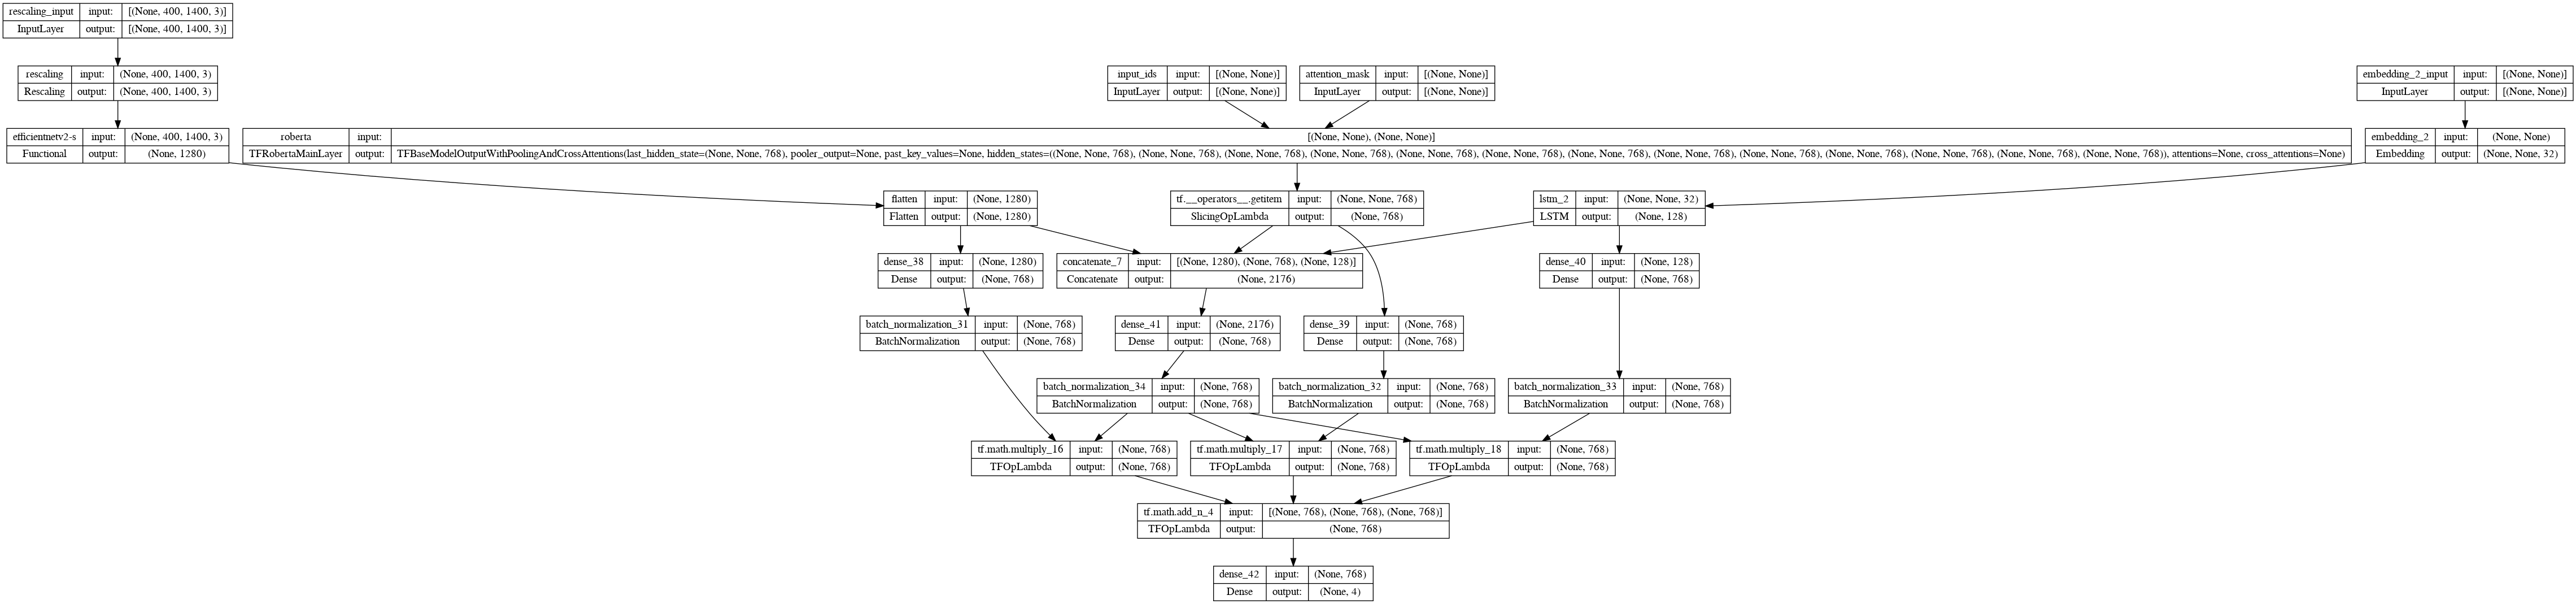

In [80]:
model_path="gmu_9.h5"

with strategy.scope():
    model = tf.keras.models.load_model(model_path)

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [10]:
import tensorflow as tf

# load the model
model = tf.keras.models.load_model('/gpfswork/rech/zpf/uyf36me/finetuning_multimodal/model_4_0')

# remove the last layer
#model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.predict(val_dataset_final.take(1)).shape


1/1 [==============================] - 41s 41s/step


(16, 4)

In [1]:
import tensorflow

2023-06-26 14:07:14.050803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
import os
import numpy as np
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
import pandas as pd
from keras.applications import EfficientNetV2B0
from tqdm import tqdm
import keras.backend as K
from tensorflow_addons.optimizers import LAMB

In [37]:
target_size = (1320, 512)
batch_size = 64

strategy = tensorflow.distribute.MirroredStrategy()

print("Number of available GPU: " + str(strategy.num_replicas_in_sync))

nb_gpu = strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of available GPU: 2


In [33]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [38]:
with strategy.scope():
    #model = EfficientNetV2B0(weights = None, classes = 3, classifier_activation = "softmax")
    model = load_model("/gpfswork/rech/zpf/ubq16fv/doc_class_thm_extraction/models/baseline_vision_shrey.h5")#("/gpfswork/rech/zpf/ubq16fv/doc_class_thm_extraction/models/ams_cnn_epoch_01_loss_1.0946_accuracy_0.3743_f1_0.1038.h5", custom_objects={"get_f1": get_f1})
    model.compile(loss = keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])#, get_f1])


In [41]:
test_df = pd.read_csv("/gpfsscratch/rech/zpf/ubq16fv/test_ohe.csv")

y_col = test_df.columns[4:].tolist()

print("test_df")
print(test_df)

print(y_col)

test_df_unique = test_df.drop_duplicates(subset='image_path')
print("test_df_unique")
print(test_df_unique)
test_df_uniqued_restricted = test_df_unique[:int(len(test_df_unique.index) / 4)]
print("test_df_uniqued_restricted")
print(test_df_uniqued_restricted)

# Normalizing pixels in [0, 1]

data_generator = image.ImageDataGenerator(preprocessing_function = lambda x: 1 - (1.0/255.0)*x)

test_generator = data_generator.flow_from_dataframe(
    dataframe = test_df_uniqued_restricted,
    x_col = 'image_path',
    y_col = y_col,
    target_size = target_size,
    batch_size = batch_size,
    class_mode ='raw',
    shuffle = False,
    validate_filenames = False
    #color_mode = "grayscale"
)


test_df
        Unnamed: 0.1  Unnamed: 0  \
0             771559      771559   
1            2553534     2553534   
2            3164791     3164791   
3              65246       65246   
4            3049600     3049600   
...              ...         ...   
980242       3664982     3664982   
980243         16723       16723   
980244       3218697     3218697   
980245       1541888     1541888   
980246       3593924     3593924   

                                               image_path  label  class_basic  \
0       /gpfsscratch/rech/zpf/ubq16fv/results/1803.061...  proof            0   
1       /gpfsscratch/rech/zpf/ubq16fv/results/1808.101...  basic            1   
2       /gpfsscratch/rech/zpf/ubq16fv/results/1810.079...  basic            1   
3       /gpfsscratch/rech/zpf/ubq16fv/results/1801.020...   rest            0   
4       /gpfsscratch/rech/zpf/ubq16fv/results/1810.045...  proof            0   
...                                                   ...    ...         

In [42]:
with strategy.scope():
    predictions = model.predict(test_generator)

2023-06-26 14:40:16.275399: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorDataset/_1"
op: "TensorDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021TensorDataset:112"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_INT32
        }
      }
    }
  }
}



3117/3117 [==============================] - 4672s 1s/step


In [43]:
import numpy as np

np.save("/gpfswork/rech/zpf/ubq16fv/doc_class_thm_extraction/predictions/baseline_shrey_pred_ams.npy", predictions)

In [44]:
u = np.load("/gpfswork/rech/zpf/ubq16fv/doc_class_thm_extraction/predictions/baseline_shrey_pred_ams.npy")

In [47]:
v = np.argmax(u, axis = 1)

In [54]:
u

array([[0.29293174, 0.5674441 , 0.13899876, 0.00062536],
       [0.29338107, 0.5671828 , 0.13881066, 0.00062549],
       [0.29300293, 0.56741637, 0.13895473, 0.00062597],
       ...,
       [0.2932694 , 0.56741583, 0.13868965, 0.0006251 ],
       [0.29354483, 0.5667132 , 0.13911614, 0.00062581],
       [0.29340366, 0.5670777 , 0.13889238, 0.00062629]], dtype=float32)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 400, 1400, 3)      0         
                                                                 
 efficientnetv2-m (Functiona  (None, 1280)             53150388  
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 53,155,512
Trainable params: 52,863,480
Non-trainable params: 292,032
_________________________________________________________________
